# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [18]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4. 

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU. 

In [19]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)    
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x) 
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x) 
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.2.2
tensor([1.])
No MPS or CUDA has been found. PyTorch will use CPU.


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model. 

In [20]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [21]:
# to avoid the permission issue when downloading datasets
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

We analyse the data to check the number of samples and their size.

In [23]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article. 

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. Since we will use the Cross Entropy loss of Pytorch, the model should output the unnormalized logits for each class.

In [24]:
## we consider a fully connected network with two hidden layers (as in the paper)

class FullyConnectedNet(nn.Module):
    # assume hidden_sizes = [hidden_size1, hidden_size2]
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        # we flatten the input so that it has shape (batch_size, input_size*input_size)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

**Question**: Create one of the model proposed in the article.

In [25]:
# paper quote
'''
Our preliminary experiments have yielded positive evidence on MNIST to support
this hypothesis as well: We have successfully trained a two layer 100-100-10 
non-convolutional neural network
'''

input_size = 28*28 # MNIST images of size (28, 28)
hidden_sizes = [100, 100]
output_size = 10

# Model
model = FullyConnectedNet(input_size=input_size, 
                          hidden_sizes=hidden_sizes, 
                          output_size=output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [26]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [27]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [28]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 0.4105
Epoch [1/5], Step [200/235], Loss: 0.2465
Epoch [2/5], Step [100/235], Loss: 0.2458
Epoch [2/5], Step [200/235], Loss: 0.1563
Epoch [3/5], Step [100/235], Loss: 0.1480
Epoch [3/5], Step [200/235], Loss: 0.2275
Epoch [4/5], Step [100/235], Loss: 0.0647
Epoch [4/5], Step [200/235], Loss: 0.1754
Epoch [5/5], Step [100/235], Loss: 0.0940
Epoch [5/5], Step [200/235], Loss: 0.1697


In [29]:
evaluation(model, test_loader)

Accuracy of test images: 96.870000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model. 

In [75]:
# modèle 3 couches 
class FullyConnectedNetV2(nn.Module):
    # assume hidden_sizes = [hidden_size1, hidden_size2, hidden_size3]
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNetV2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        # we flatten the input so that it has shape (batch_size, input_size*input_size)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# modèle 4 couches
class FullyConnectedNetV3(nn.Module):
    # three hidden layers
    # assume hidden_sizes = [hidden_size1, hidden_size2, hidden_size3, hidden_size4]
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNetV3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

    def forward(self, x):
        # we flatten the input so that it has shape (batch_size, input_size*input_size)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

In [31]:
input_size = 28*28 # MNIST images of size (28, 28)
hidden_sizes = [100, 100]
hidden_sizes_2 = [100, 100, 100]
hidden_sizes_3 = [100, 100, 100, 100]
output_size = 10

# Model
model_v2 = FullyConnectedNetV2(input_size=input_size, 
                               hidden_sizes=hidden_sizes_2, 
                               output_size=output_size).to(device)

# Model
model_v3 = FullyConnectedNetV3(input_size=input_size, 
                               hidden_sizes=hidden_sizes_3, 
                               output_size=output_size).to(device)

# Optimizer
optimizer_2 = optim.Adam(model_v2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_3 = optim.Adam(model_v3.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [32]:
# Training loop
training(model_v2, train_loader, optimizer_2, num_epochs, loss_model)
training(model_v3, train_loader, optimizer_3, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 0.3034
Epoch [1/5], Step [200/235], Loss: 0.3142
Epoch [2/5], Step [100/235], Loss: 0.1470
Epoch [2/5], Step [200/235], Loss: 0.2056
Epoch [3/5], Step [100/235], Loss: 0.1219
Epoch [3/5], Step [200/235], Loss: 0.1107
Epoch [4/5], Step [100/235], Loss: 0.1584
Epoch [4/5], Step [200/235], Loss: 0.1120
Epoch [5/5], Step [100/235], Loss: 0.0946
Epoch [5/5], Step [200/235], Loss: 0.0963
Epoch [1/5], Step [100/235], Loss: 0.5439
Epoch [1/5], Step [200/235], Loss: 0.3009
Epoch [2/5], Step [100/235], Loss: 0.1921
Epoch [2/5], Step [200/235], Loss: 0.1785
Epoch [3/5], Step [100/235], Loss: 0.1392
Epoch [3/5], Step [200/235], Loss: 0.1414
Epoch [4/5], Step [100/235], Loss: 0.1429
Epoch [4/5], Step [200/235], Loss: 0.1571
Epoch [5/5], Step [100/235], Loss: 0.1091
Epoch [5/5], Step [200/235], Loss: 0.1103


In [33]:
print("Model 1 evaluation (2 hidden layers):")
evaluation(model, test_loader)
print("*************************************")
print("Model 2 evaluation (3 hidden layers): ")
evaluation(model_v2, test_loader)
print("*************************************")
print("Model 3 evaluation (4 hidden layers): ")
evaluation(model_v3, test_loader)

Model 1 evaluation (2 hidden layers):
Accuracy of test images: 96.870000 %
*************************************
Model 2 evaluation (3 hidden layers): 
Accuracy of test images: 96.830000 %
*************************************
Model 3 evaluation (4 hidden layers): 
Accuracy of test images: 96.450000 %


We look at what happens if we change training parameters. For instance, we increase `num_epochs` to 10.

In [34]:
num_epochs = 10

# Model
model_10ep = FullyConnectedNet(input_size=input_size, 
                               hidden_sizes=hidden_sizes, 
                               output_size=output_size).to(device)

# Model
model_v2_10ep = FullyConnectedNetV2(input_size=input_size, 
                               hidden_sizes=hidden_sizes_2, 
                               output_size=output_size).to(device)

# Model
model_v3_10ep = FullyConnectedNetV3(input_size=input_size, 
                               hidden_sizes=hidden_sizes_3, 
                               output_size=output_size).to(device)

# Optimizer
optimizer_ep10 = optim.Adam(model_10ep.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_2_ep10 = optim.Adam(model_v2_10ep.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_3_ep10 = optim.Adam(model_v3_10ep.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
training(model_10ep, train_loader, optimizer_ep10, num_epochs, loss_model)
training(model_v2_10ep, train_loader, optimizer_2_ep10, num_epochs, loss_model)
training(model_v3_10ep, train_loader, optimizer_3_ep10, num_epochs, loss_model)

Epoch [1/10], Step [100/235], Loss: 0.2812
Epoch [1/10], Step [200/235], Loss: 0.2105
Epoch [2/10], Step [100/235], Loss: 0.2468
Epoch [2/10], Step [200/235], Loss: 0.1638
Epoch [3/10], Step [100/235], Loss: 0.1478
Epoch [3/10], Step [200/235], Loss: 0.2344
Epoch [4/10], Step [100/235], Loss: 0.1578
Epoch [4/10], Step [200/235], Loss: 0.1089
Epoch [5/10], Step [100/235], Loss: 0.1575
Epoch [5/10], Step [200/235], Loss: 0.1400
Epoch [6/10], Step [100/235], Loss: 0.0573
Epoch [6/10], Step [200/235], Loss: 0.1527
Epoch [7/10], Step [100/235], Loss: 0.0736
Epoch [7/10], Step [200/235], Loss: 0.0738
Epoch [8/10], Step [100/235], Loss: 0.0445
Epoch [8/10], Step [200/235], Loss: 0.0637
Epoch [9/10], Step [100/235], Loss: 0.0752
Epoch [9/10], Step [200/235], Loss: 0.0395
Epoch [10/10], Step [100/235], Loss: 0.0422
Epoch [10/10], Step [200/235], Loss: 0.0332
Epoch [1/10], Step [100/235], Loss: 0.4171
Epoch [1/10], Step [200/235], Loss: 0.2661
Epoch [2/10], Step [100/235], Loss: 0.1849
Epoch [2/

In [35]:
print("Model 1 evaluation (2 hidden layers - 10 epochs):")
evaluation(model_10ep, test_loader)
print("*************************************")
print("Model 2 evaluation (3 hidden layers - 10 epochs): ")
evaluation(model_v2_10ep, test_loader)
print("*************************************")
print("Model 3 evaluation (4 hidden layers - 10 epochs): ")
evaluation(model_v3_10ep, test_loader)

Model 1 evaluation (2 hidden layers - 10 epochs):
Accuracy of test images: 97.380000 %
*************************************
Model 2 evaluation (3 hidden layers - 10 epochs): 
Accuracy of test images: 97.370000 %
*************************************
Model 3 evaluation (4 hidden layers - 10 epochs): 
Accuracy of test images: 97.560000 %


We notice that, logically, increasing the number of epochs (`num_epochs=10`) leads to an improved training and a better out-of-sample performance of the models. We also notice that increasing the number of hidden layers, that is changing the architecture, does not yield better performances. We thus consider the case `nump_epochs=10`(we could try higher values of this hyperparameter but, due to computational constraints, we won't) and the initial architecture with two hidden layers. With this choice in mind, we make one last experiment by increasing the `weight_decay` hyperparameter.

In the experiment of the paper [Szegedy et al.](https://arxiv.org/pdf/1312.6199), they use for the MNIST experiments a regularization with a weight decay of $\lambda \in \{10^{-4}, 10^{-2}, 1\}$.

In [36]:
num_epochs = 10

# Model
model_10ep_wd1 = FullyConnectedNet(input_size=input_size, 
                               hidden_sizes=hidden_sizes, 
                               output_size=output_size).to(device)
model_10ep_wd2 = FullyConnectedNet(input_size=input_size, 
                               hidden_sizes=hidden_sizes, 
                               output_size=output_size).to(device)
model_10ep_wd3 = FullyConnectedNet(input_size=input_size, 
                               hidden_sizes=hidden_sizes, 
                               output_size=output_size).to(device)

weight_decay_1 = 10e-4
weight_decay_2 = 10e-2
weight_decay_3 = 1

# Optimizer
optimizer_ep10_wd1 = optim.Adam(model_10ep_wd1.parameters(), lr=learning_rate, weight_decay=weight_decay_1)
optimizer_ep10_wd2 = optim.Adam(model_10ep_wd2.parameters(), lr=learning_rate, weight_decay=weight_decay_2)
optimizer_ep10_wd3 = optim.Adam(model_10ep_wd3.parameters(), lr=learning_rate, weight_decay=weight_decay_3)

# Training loop
training(model_10ep_wd1, train_loader, optimizer_ep10_wd1, num_epochs, loss_model)
training(model_10ep_wd2, train_loader, optimizer_ep10_wd2, num_epochs, loss_model)
training(model_10ep_wd3, train_loader, optimizer_ep10_wd3, num_epochs, loss_model)

Epoch [1/10], Step [100/235], Loss: 0.4072
Epoch [1/10], Step [200/235], Loss: 0.2010
Epoch [2/10], Step [100/235], Loss: 0.3154
Epoch [2/10], Step [200/235], Loss: 0.2471
Epoch [3/10], Step [100/235], Loss: 0.1503
Epoch [3/10], Step [200/235], Loss: 0.1334
Epoch [4/10], Step [100/235], Loss: 0.1469
Epoch [4/10], Step [200/235], Loss: 0.1815
Epoch [5/10], Step [100/235], Loss: 0.1395
Epoch [5/10], Step [200/235], Loss: 0.1023
Epoch [6/10], Step [100/235], Loss: 0.1069
Epoch [6/10], Step [200/235], Loss: 0.1601
Epoch [7/10], Step [100/235], Loss: 0.0798
Epoch [7/10], Step [200/235], Loss: 0.0730
Epoch [8/10], Step [100/235], Loss: 0.0823
Epoch [8/10], Step [200/235], Loss: 0.0468
Epoch [9/10], Step [100/235], Loss: 0.0733
Epoch [9/10], Step [200/235], Loss: 0.0659
Epoch [10/10], Step [100/235], Loss: 0.1139
Epoch [10/10], Step [200/235], Loss: 0.0902
Epoch [1/10], Step [100/235], Loss: 1.1704
Epoch [1/10], Step [200/235], Loss: 1.0365
Epoch [2/10], Step [100/235], Loss: 0.9411
Epoch [2/

In [37]:
print("Model 1 evaluation (lambda = 10e-4):")
evaluation(model_10ep_wd1, test_loader)
print("*************************************")
print("Model 2 evaluation (lambda = 10e-2): ")
evaluation(model_10ep_wd2, test_loader)
print("*************************************")
print("Model 3 evaluation (lambda = 1): ")
evaluation(model_10ep_wd3, test_loader)

Model 1 evaluation (lambda = 10e-4):
Accuracy of test images: 97.000000 %
*************************************
Model 2 evaluation (lambda = 10e-2): 
Accuracy of test images: 75.480000 %
*************************************
Model 3 evaluation (lambda = 1): 
Accuracy of test images: 11.350000 %


Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : \mathbb{R}^m \rightarrow \{1 . . . k\}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : \mathbb{R}^m × \{1 . . . k\} \rightarrow \mathbb{R}^+$. For a given $x \in \mathbb{R}^m$ image and target label $l \in \{1 . . . k\}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [38]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=300
initial_c = 0.000001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

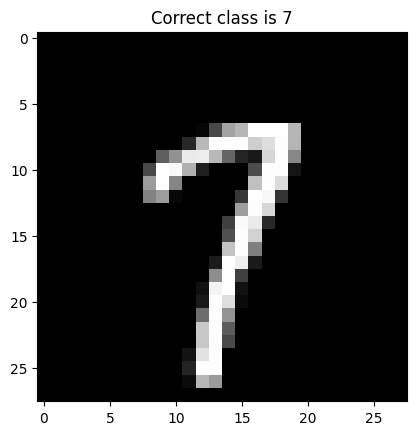

In [39]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [40]:
def plot_results(X, r, Xr, Y, l, fail=True):

    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 7, the new class will be 6
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 90.8369369506836


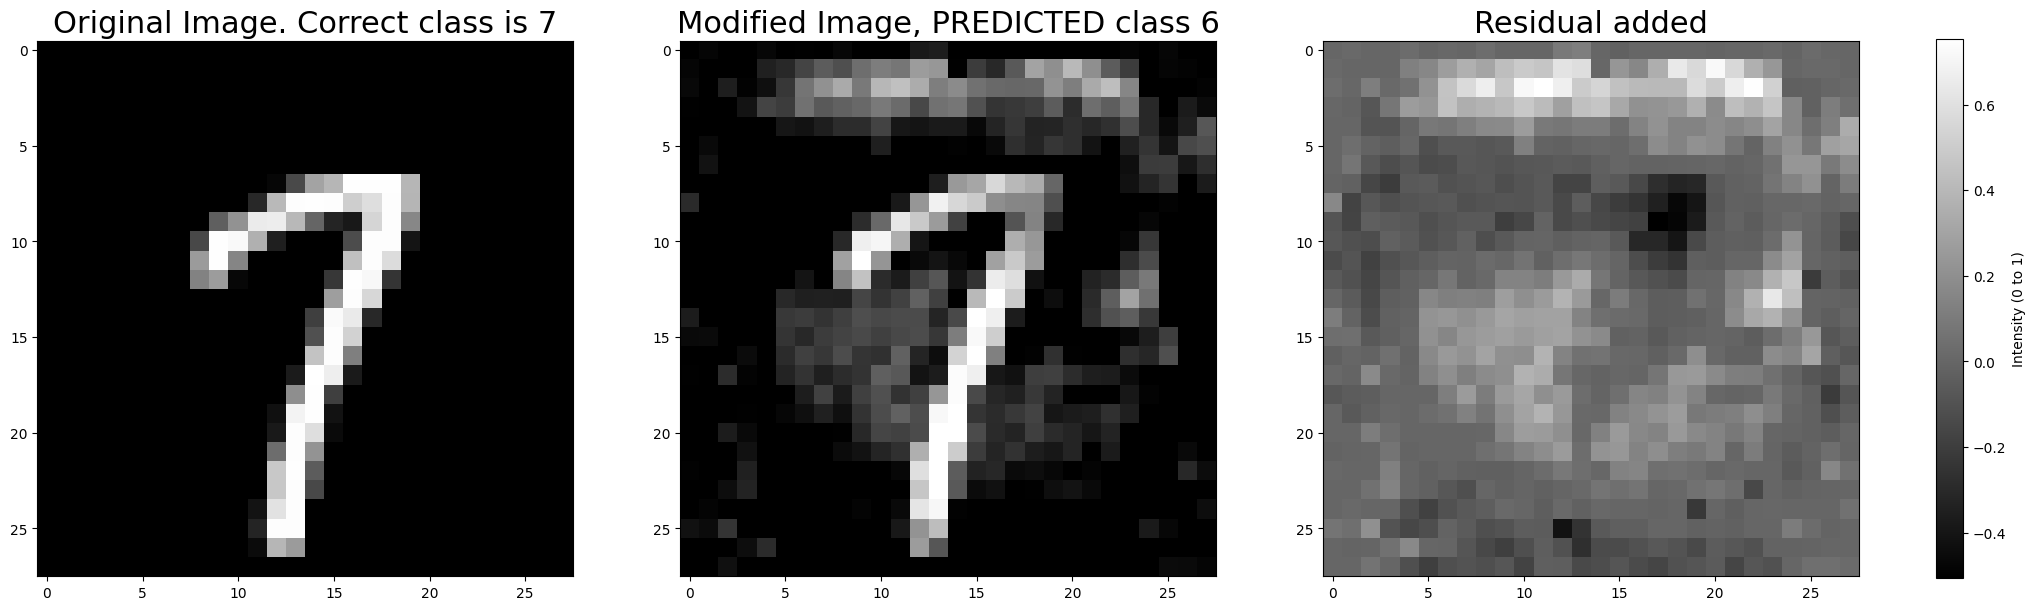

In [45]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
# manually chosen target class label different from true one
label=6 # the true class is 7
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")
loss_f = nn.CrossEntropyLoss()

# Define the loss function : c|r| + \text{loss}_f (x + r, l)
def objective(c, r, x, l):
    x_r = torch.clamp(x + r, 0, 1)  # Ensure valid range for x + r
    pred = model(x_r)  # Get logits from the model
    return c*torch.abs(r).sum() + loss_f(pred, l)

# Parameters adversarial example
index=666 # index test image to use

# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):    
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optimizerLBFGS = optim.LBFGS([r],
                                                  lr=lr_LBFGS,
                                                  max_iter=max_iter_LBFGS,
                                                  tolerance_grad=epsilon_LBFGS,  # Gradient stopping tolerance
                                                  tolerance_change=epsilon_LBFGS,  # Function change stopping tolerance
                                                  line_search_fn='strong_wolfe'
                                                  )

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    # If not satisfied, increase c
    c *= mult_c # Adjust step size for line search
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ? Would you prefer a small or large value of `c`? Why ? 

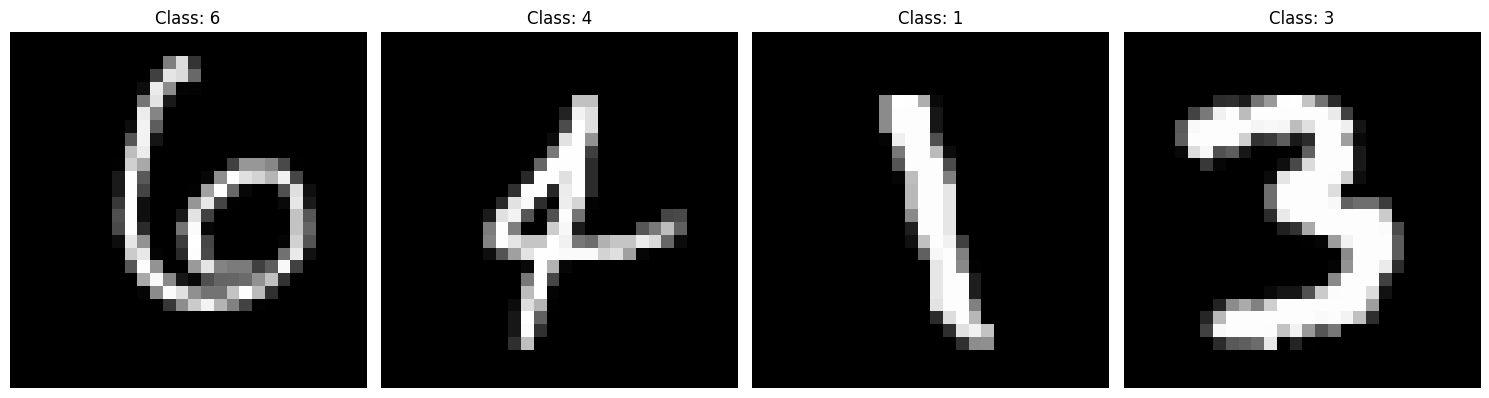

In [47]:
# We consider a list of index associated to various labels
index_list = [100, 300, 700, 500]

# Nombre d'images
num_images = len(index_list)

img_list = []

# Création du subplot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # 1 ligne, `num_images` colonnes

# Boucle pour remplir chaque sous-graphe
for i, index in enumerate(index_list):
    testI2, testY2 = mnist_test.__getitem__(index)
    img_list.append((testI2, testY2))
    axes[i].imshow(testI2.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
    axes[i].set_title(f"Class: {testY2}")
    axes[i].axis('off')  # Désactive les axes pour un affichage plus propre

# Ajuste l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

It is recalled that the hyperparameters we used for c were `initial_c`, `max_c`, `mult_c`. If we are to test whether the algorithm always converge, we should consider other values of these parameters. First, for convenience, we define the previous code that runs the optimisation problem as a function that takes relevant parameters.

In [82]:
def experiment(model, testI, testY, label, initial_c, max_c, mult_c, lr_LBFGS=0.1, max_iter_LBFGS=100, plot=True):
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)  
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    print(f"The true class is {testY}, the new class will be {l[0]}")
    loss_f = nn.CrossEntropyLoss()

    # Define the loss function : c|r| + \text{loss}_f (x + r, l)
    def objective(c, r, x, l):
        x_r = torch.clamp(x + r, 0, 1)  # Ensure valid range for x + r
        pred = model(x_r)  # Get logits from the model
        return c*torch.abs(r).sum() + loss_f(pred, l)

    # Line search to find the minimum c > 0
    c = initial_c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):    
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optimizerLBFGS = optim.LBFGS([r],
                                                    lr=lr_LBFGS,
                                                    max_iter=max_iter_LBFGS,
                                                    tolerance_grad=epsilon_LBFGS,  # Gradient stopping tolerance
                                                    tolerance_change=epsilon_LBFGS,  # Function change stopping tolerance
                                                    line_search_fn='strong_wolfe'
                                                    )
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)


        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            iter=iter+1
            break
        else:
            iter=iter+1

        # If not satisfied, increase c
        c *= mult_c # Adjust step size for line search
        if (iter) % 20 == 0:
            print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

    if (c > max_c) or (iter > max_iter_search):
        print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, testY, l, fail=True)

    else:
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    if plot:
        plot_results(testI, r, x_r, testY, l, fail=False)


    return torch.norm(r, p=1)

In this part, we look to break the convergence. This is achieved by increasing `initial_c` and `max_c` to 0.9

********************************
img index=100
The true class is 6, the new class will be 5
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


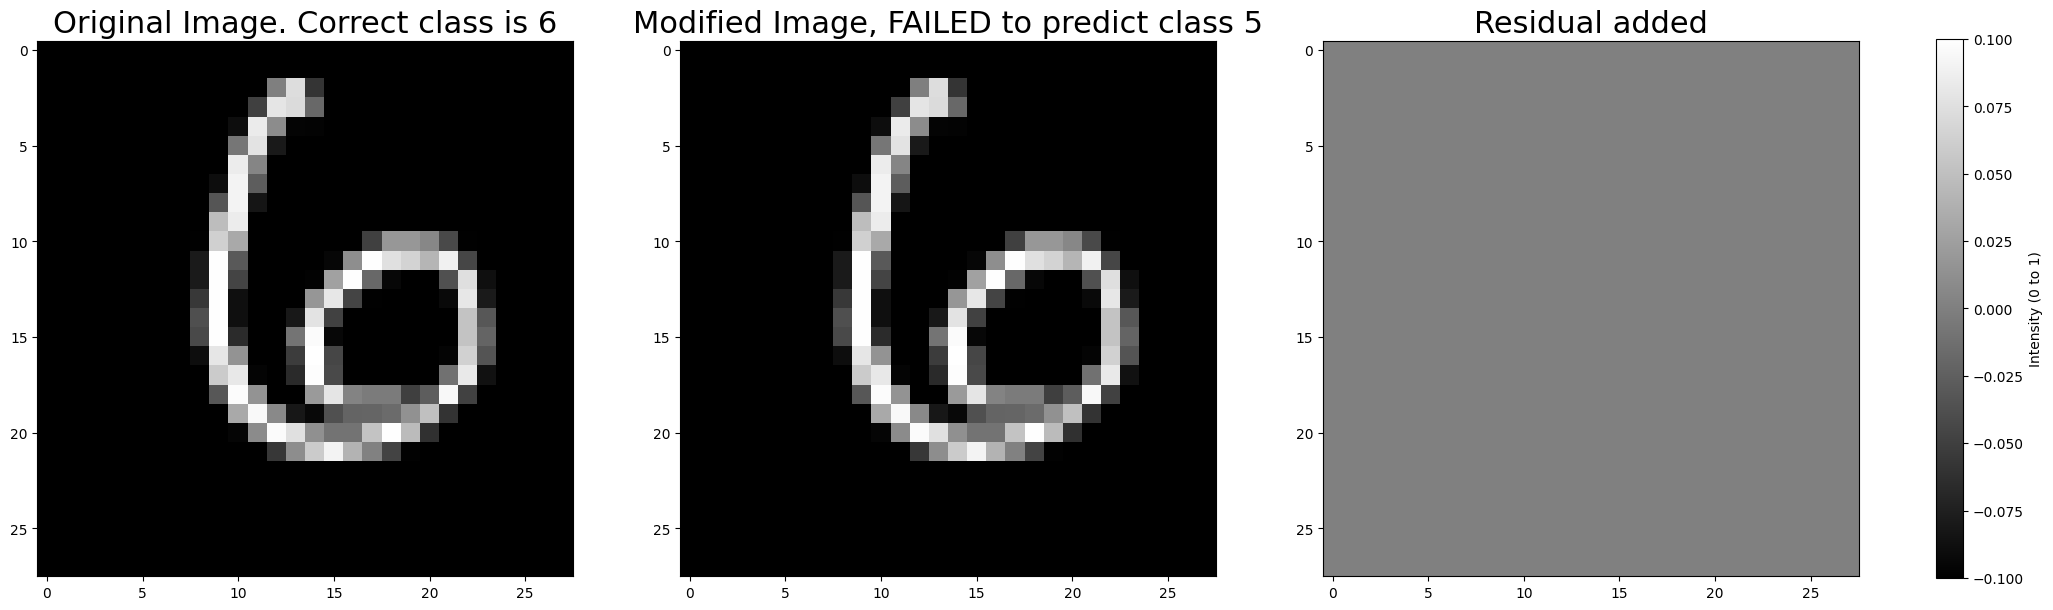

********************************
img index=300
The true class is 4, the new class will be 2
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


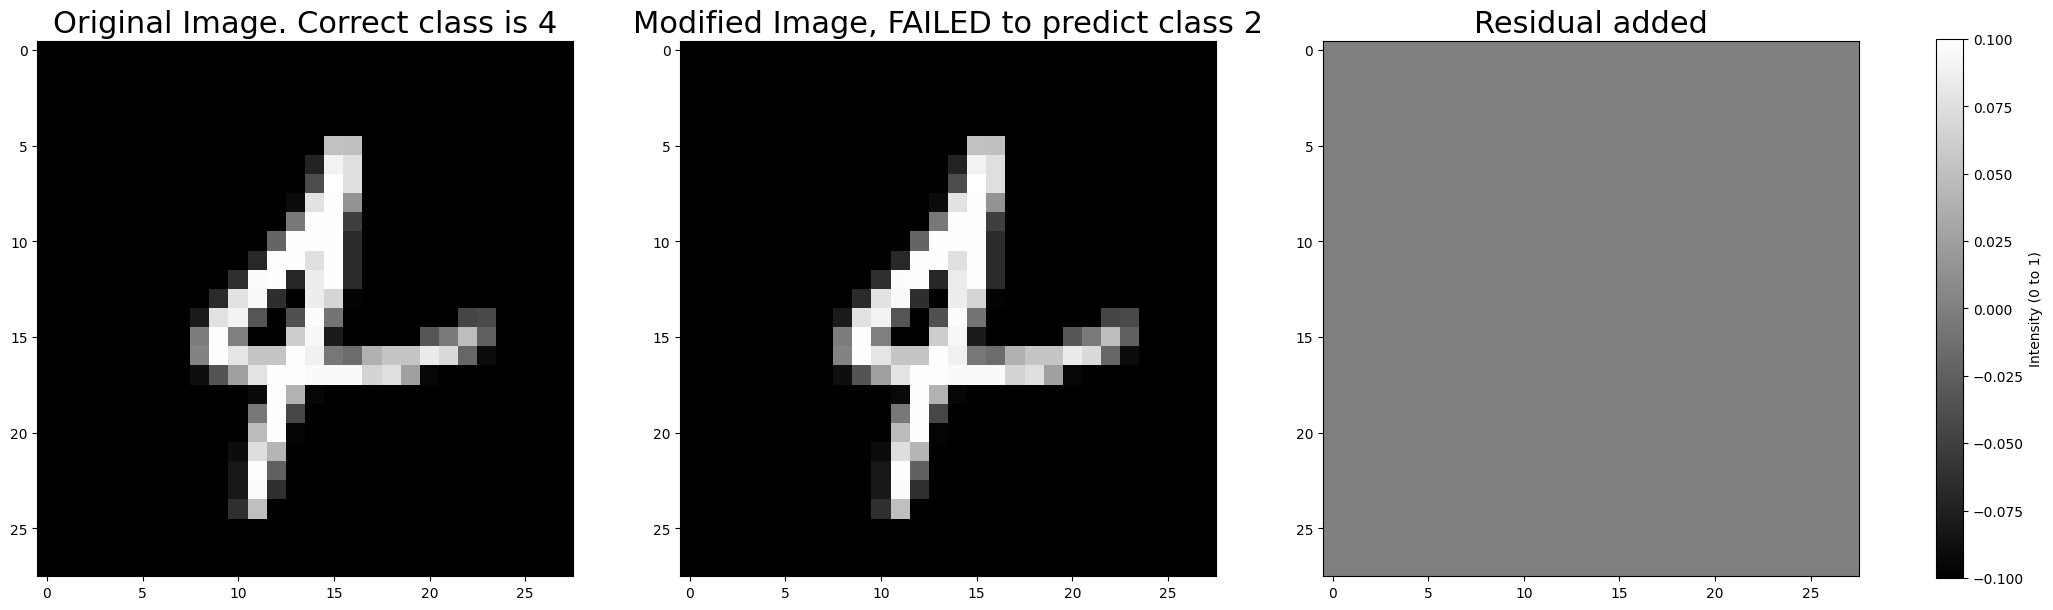

********************************
img index=700
The true class is 1, the new class will be 4
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


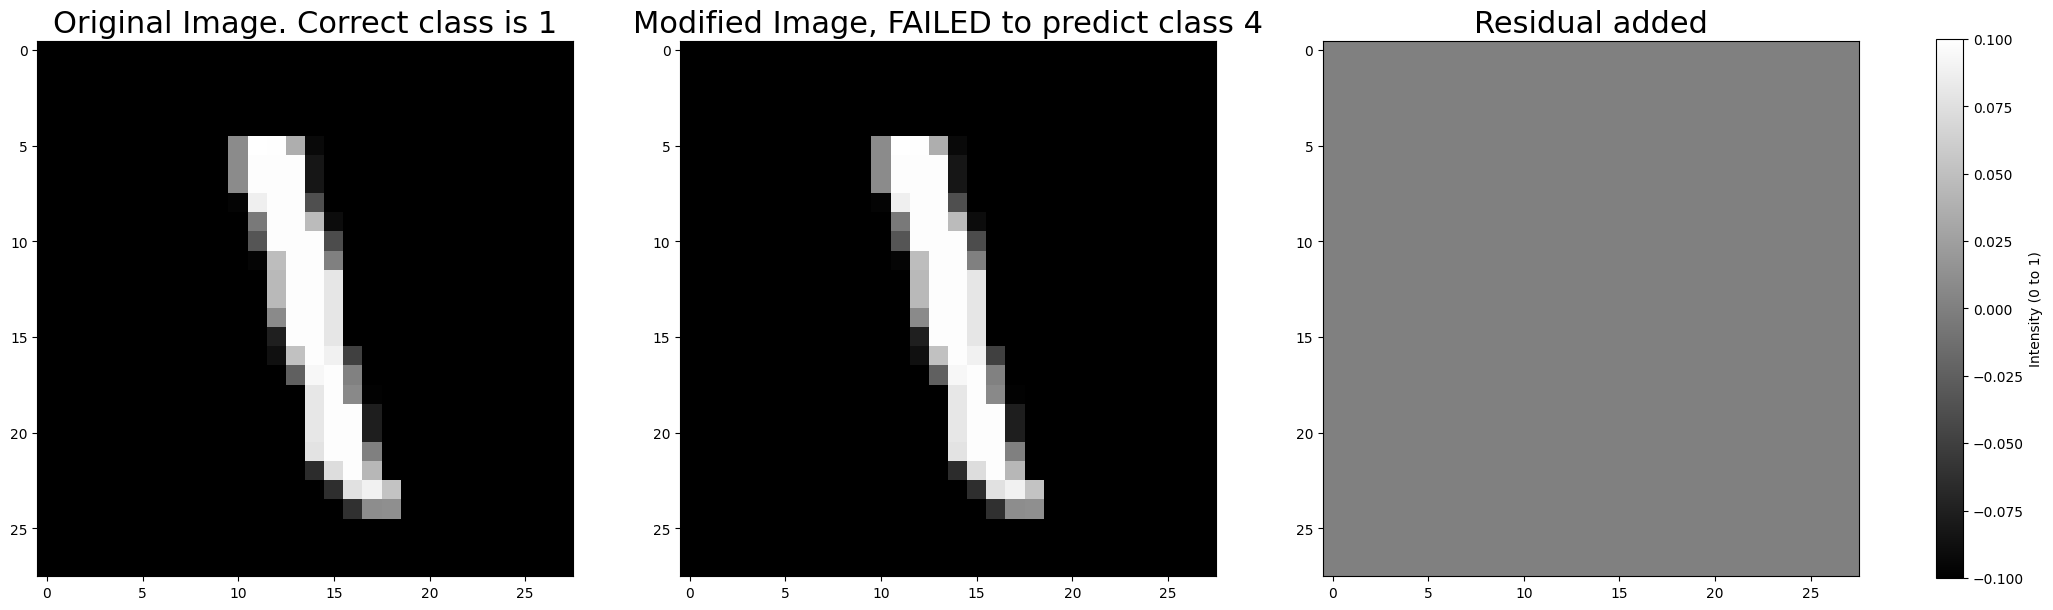

********************************
img index=500
The true class is 3, the new class will be 1
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


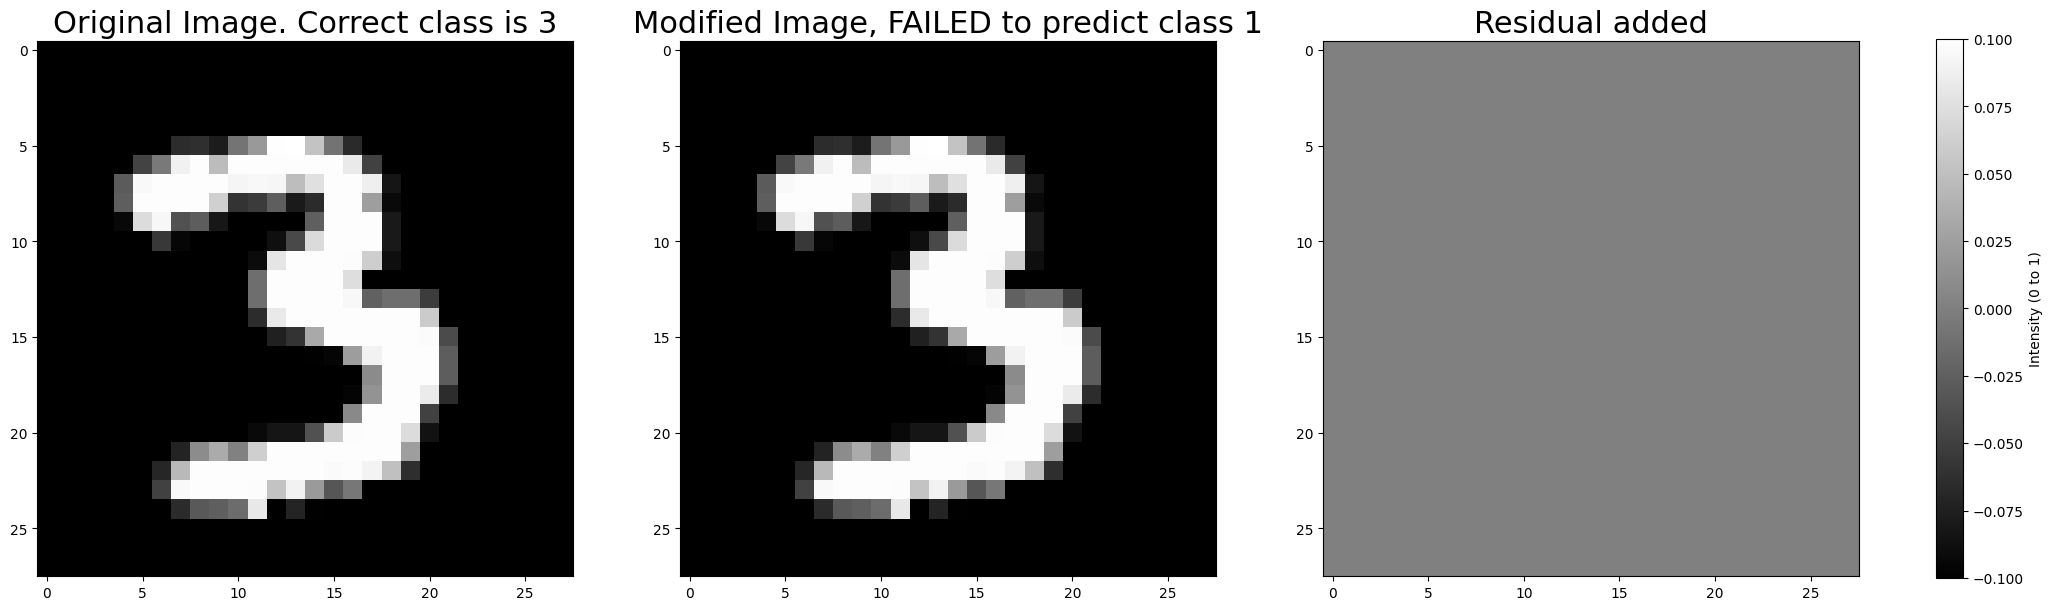

In [66]:
# the labels associated to each index are 6, 4, 1, 3 thus we chose the following list of false labels
labels = [5, 2, 4, 1]
initial_c = 0.9  # previous value : 0.000001
max_c = 0.9 # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

for i, (testI, testY) in enumerate(img_list):
    print('********************************')
    print(f'img index={index_list[i]}')
    experiment(testI, testY, labels[i], initial_c, max_c, mult_c)

Now, we reconsider the case when it converges. We notice that in this case, the modified images corresponds roughly to the original image. It should be clearly classified as belonging in the same class as the original image. In the following, the modified image clearly corresponds to a 6 and not to a 5. 

In [81]:
# Extract all images and labels for class 6 in one line
images_of_six = np.array([mnist_train[i][0].numpy() for i in range(len(mnist_train)) if mnist_train[i][1] == 6])
labels_of_six = np.array([6] * len(images_of_six)) 

In [92]:
initial_c = 0.000001
max_c = 0.01 # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c
mnist_test
num_it = 100
S_r = 0
for i in range(min(num_it,len(images_of_six))):
    S_r += experiment(model, torch.tensor(images_of_six[i]), 6, 5, initial_c, max_c, mult_c, plot=False)

S_r = S_r / num_it

print('********************************')
print(f'The average value of |r| is {S_r}')

The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 60.042144775390625
The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 37.60544967651367
The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 45.360103607177734
The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 40.31210708618164
The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 56.10869598388672
The true class is 6, the new class will be 5
Found c = 0.000001 sati

The average value of $|r|$ over 6's is 69.09. 

**Question** What if you try with different networks ? Test with at least one other network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed. 

We recall that the various models we previously introduced are: 

- `model_10ep_wd1`, `model_10ep_wd2` and `model_10ep_wd3`
- `model_10ep`, `model_v2_10ep` and `model_v3_10ep`
- `model_v2` and `model_v3`

We will only retain `model_10ep`, `model_v2_10ep` and `model_v3_10ep` as these models showed the best out-of-sample accuracies (97.380000 %, 97.370000 % and 97.560000 %).

The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 71.23887634277344


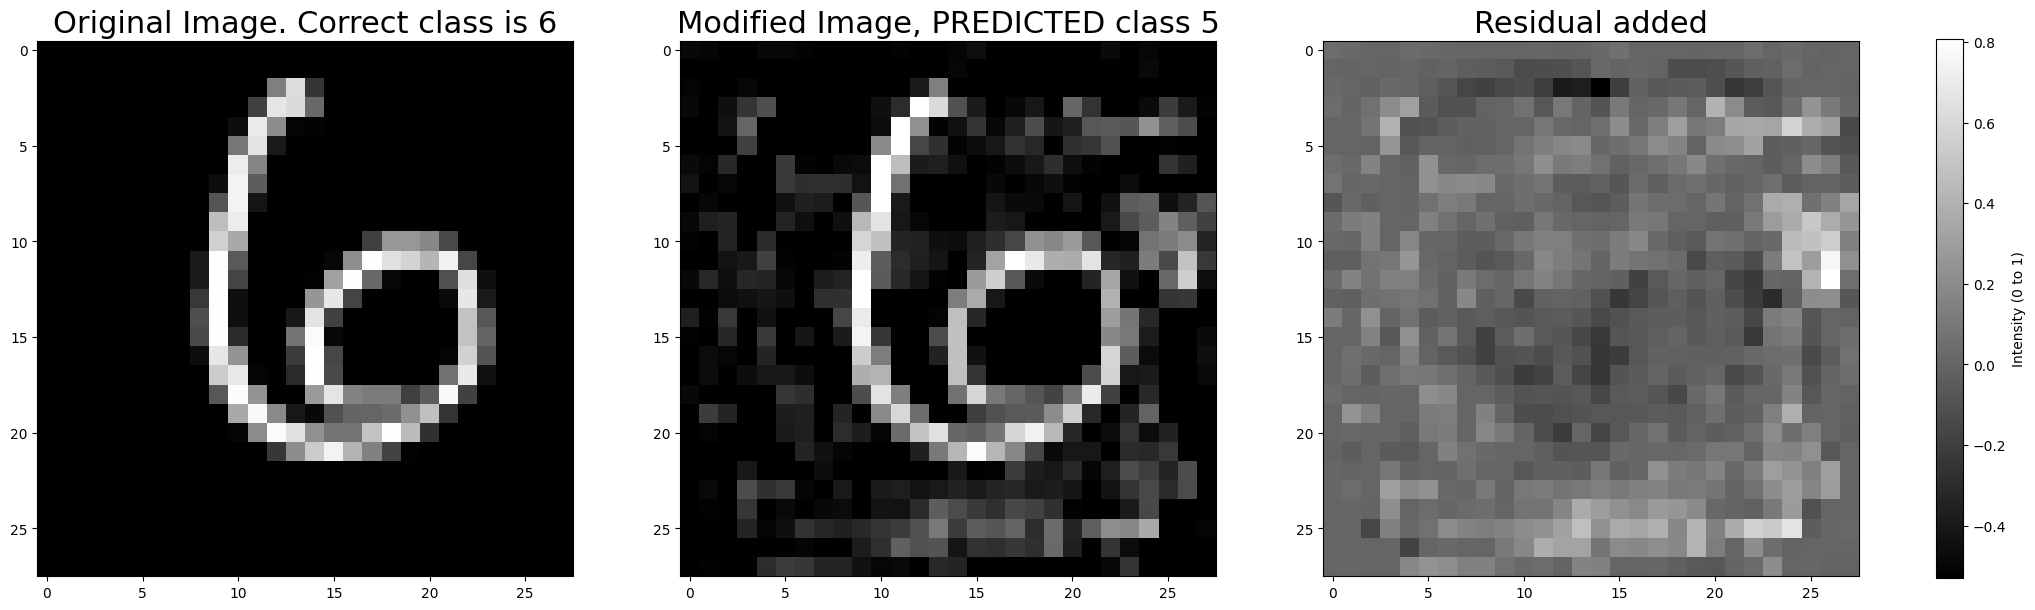

The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 66.30790710449219


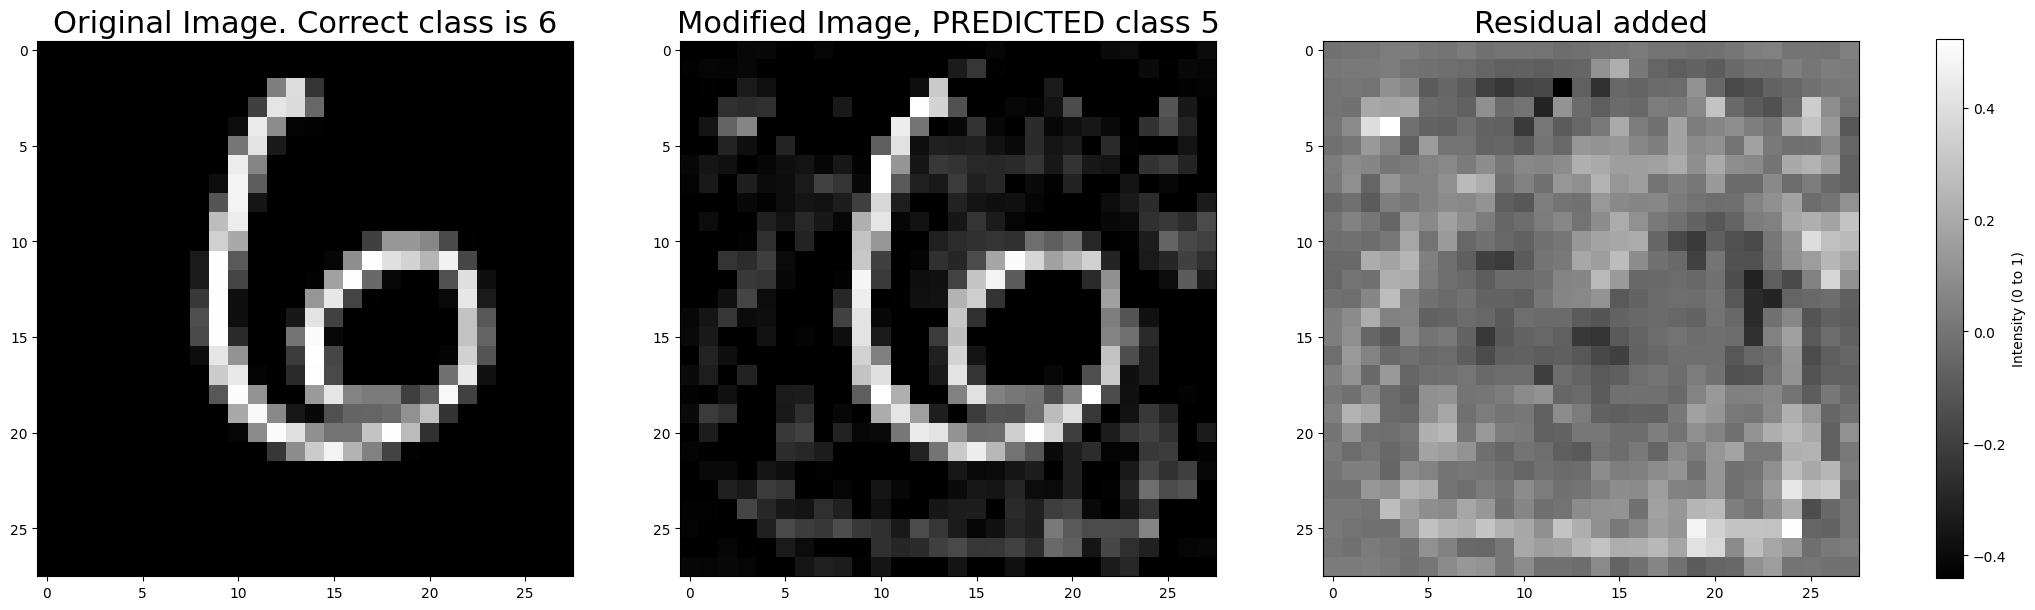

The true class is 6, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 32.2812614440918


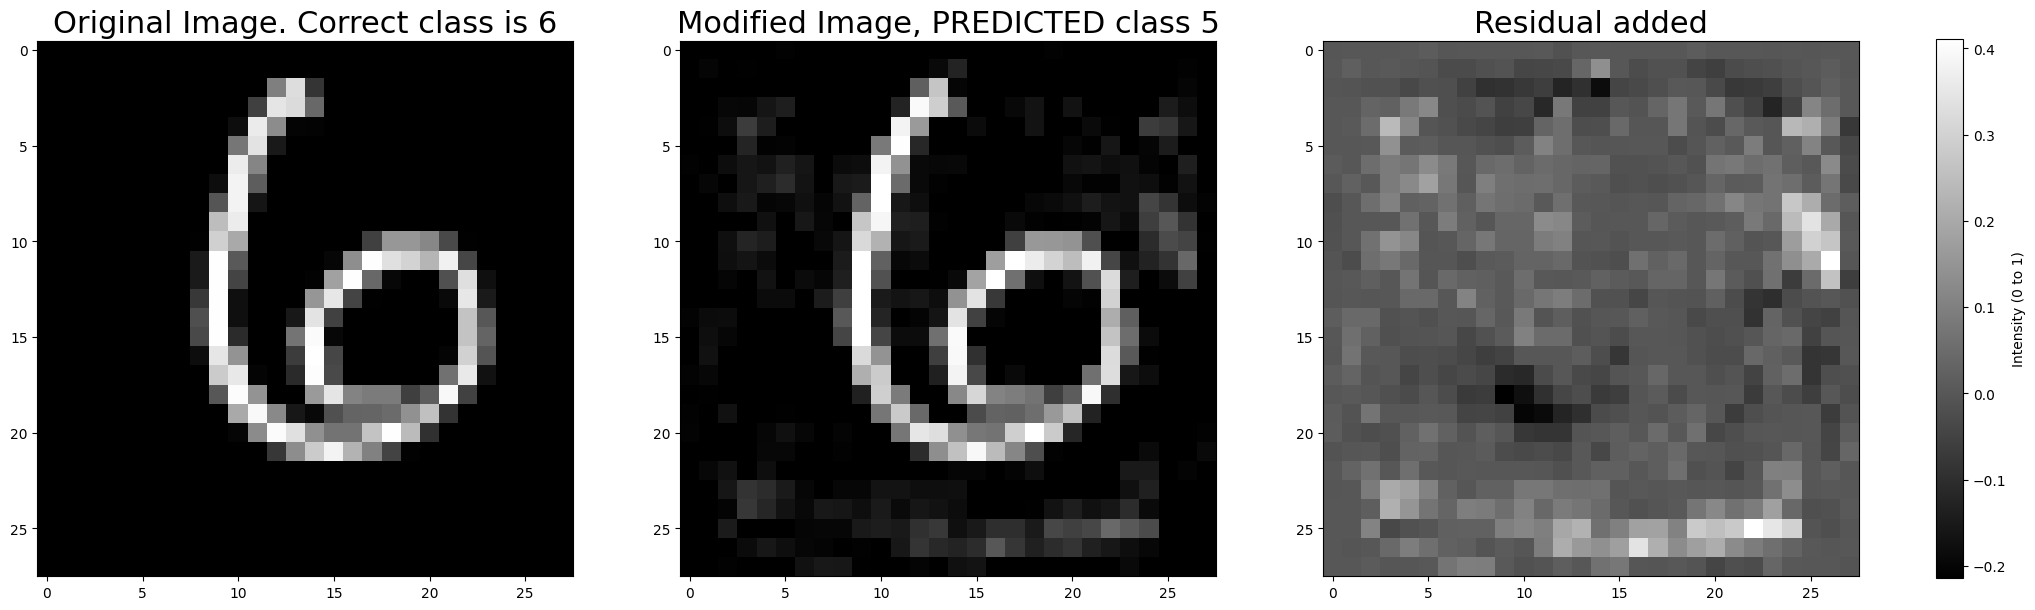

tensor(32.2813, grad_fn=<LinalgVectorNormBackward0>)

In [103]:
testI, testY = img_list[0]

initial_c = 0.000001
max_c = 0.01 # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

# model_10ep : 1 hidden layer
experiment(model_10ep, testI, testY, labels[0], initial_c, max_c, mult_c)

# model_v2_10ep : 2 hidden layers
experiment(model_v2_10ep, testI, testY, labels[0], initial_c, max_c, mult_c)

# model_v3_10ep : 3 hidden layers
experiment(model_v3_10ep, testI, testY, labels[0], initial_c, max_c, mult_c)

The optimisation converges, and, to a naked eye, the initial image should be classified as a 6, even though the residual added looks significant.

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

We produce a set of adversarial instances for the network `model_10ep` and the class 6. We take as a fake class 5. 

In [119]:
def create_adversarial(model, testI, testY, label, initial_c, max_c, mult_c, lr_LBFGS=0.1, max_iter_LBFGS=100, plot=True):
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)  
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    print(f"The true class is {testY}, the new class will be {l[0]}")
    loss_f = nn.CrossEntropyLoss()

    # Define the loss function : c|r| + \text{loss}_f (x + r, l)
    def objective(c, r, x, l):
        x_r = torch.clamp(x + r, 0, 1)  # Ensure valid range for x + r
        pred = model(x_r)  # Get logits from the model
        return c*torch.abs(r).sum() + loss_f(pred, l)

    # Line search to find the minimum c > 0
    c = initial_c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):    
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optimizerLBFGS = optim.LBFGS([r],
                                                    lr=lr_LBFGS,
                                                    max_iter=max_iter_LBFGS,
                                                    tolerance_grad=epsilon_LBFGS,  # Gradient stopping tolerance
                                                    tolerance_change=epsilon_LBFGS,  # Function change stopping tolerance
                                                    line_search_fn='strong_wolfe'
                                                    )
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)


        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            iter=iter+1
            break
        else:
            iter=iter+1

        # If not satisfied, increase c
        c *= mult_c # Adjust step size for line search
        if (iter) % 20 == 0:
            print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

    if (c > max_c) or (iter > max_iter_search):
        print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, testY, l, fail=True)

    else:
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    if plot:
        plot_results(testI, r, x_r, testY, l, fail=False)


    return x_r

initial_c = 0.000001
max_c = 0.01 # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c
label = 5 # fake label
testY = torch.tensor([6]) # true class
num_it = 500
badly_pred_1, badly_pred_2 = 0, 0
for i in range(min(num_it,len(images_of_six))):
    x_r_model10ep = create_adversarial(model_10ep, torch.tensor(images_of_six[i]), testY, label, initial_c, max_c, mult_c, plot=False)
    pred_model_v2_10ep = torch.argmax(model_v2_10ep(x_r_model10ep), dim=1)
    pred_model_v3_10ep = torch.argmax(model_v3_10ep(x_r_model10ep), dim=1)
    badly_pred_1 += int((pred_model_v2_10ep != testY))
    badly_pred_2 += int((pred_model_v3_10ep != testY))
print('*********************************')
print('*********************************')
print(f'The number of adversarial instances for the first badly classified by the second model is {badly_pred_1} out of {num_it} adversarial instances')
print('*********************************')
print(f'The number of adversarial instances for the first badly classified by the third model is {badly_pred_2} out of {num_it} adversarial instances')

The true class is tensor([6]), the new class will be 5


Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 34.206424713134766
The true class is tensor([6]), the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 26.872835159301758
The true class is tensor([6]), the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 34.67815399169922
The true class is tensor([6]), the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 35.888458251953125
The true class is tensor([6]), the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 41.81747055053711
The true class is tensor([6]), the new class will be 5
Found c = 0.00000

It looks like adversarial instances produced for network `model_10ep` are also misclassified by models `model_v2_10ep` and `model_v3_10ep`, even though, interestingly it is observed that the last model `model_v3_10ep`, the **best trained one**, is able to correctly classify one adversarial example. 

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c. 

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Would you minimize or maximize c ? Please comment on that. 

First, we consider the case where we fix $c$ and optimize $r$ only.

In [102]:
max_iter_adam = 100  # Maximum iterations for L-BFGS
lr_adam = 0.1  # Learning rate for L-BFGS

Optimization succeeded at iteration 0 with fixed c = 1e-06
Norm Perturbation |r|: 78.39520263671875


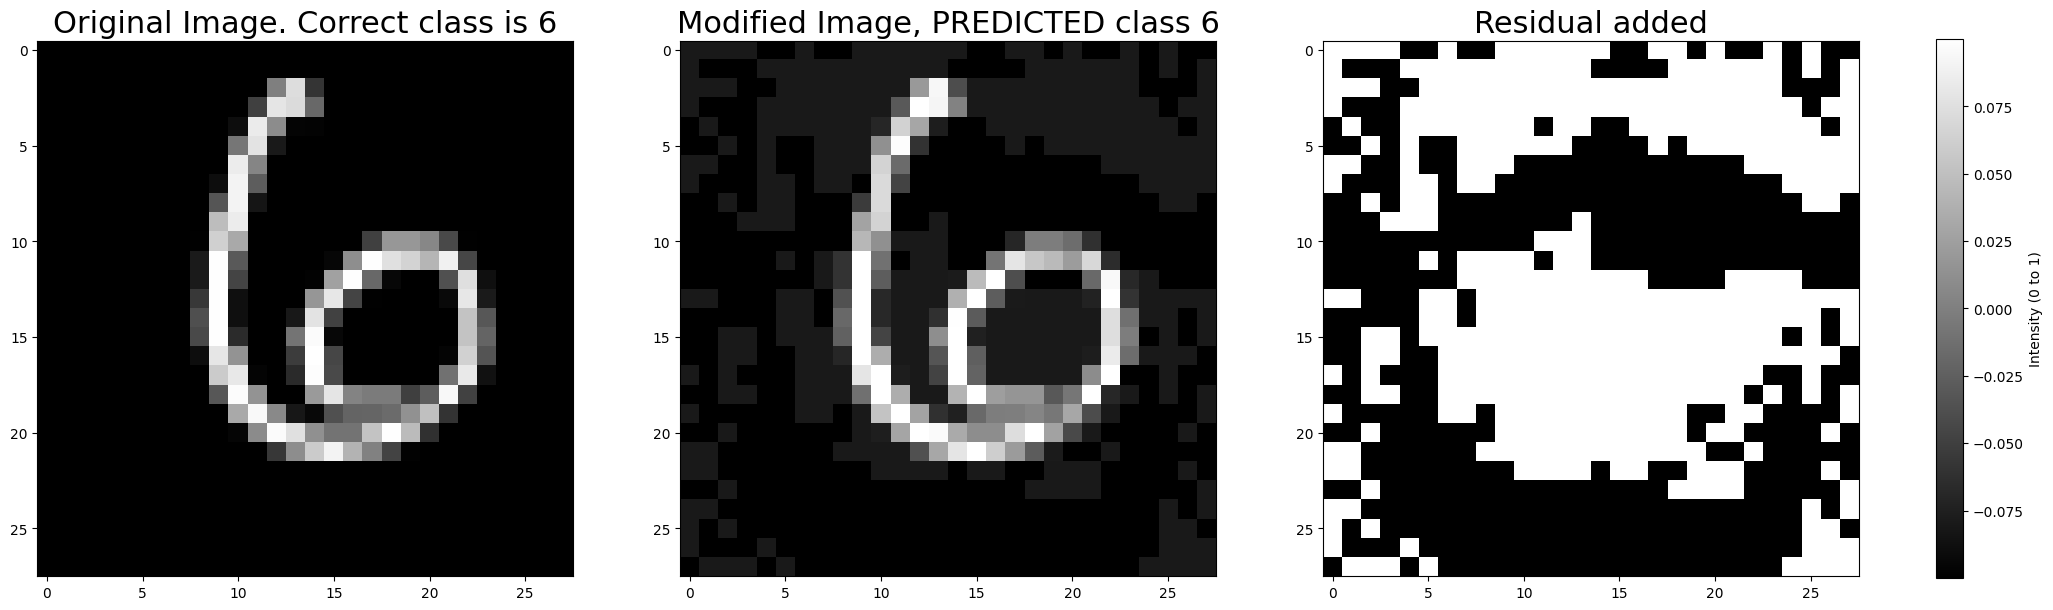

In [73]:
# Parameters
c = initial_c  # Fixed value for c
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r
optimizer = optim.Adam([r], lr=lr_adam)  # Adam optimizer for r

# Optimization loop
for iter in range(max_iter_adam):
    optimizer.zero_grad()
    loss = objective(c, r, testI, l)  # Compute the loss
    loss.backward()  # Backpropagate gradients
    optimizer.step()  # Update r

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition is satisfied
    if predicted_label == l:
        print(f"Optimization succeeded at iteration {iter} with fixed c = {c}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=False)
        break
else:
    print("Failed to find adversarial example within the maximum iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)


It does not work properly, since the model still classifies the correct label.

Now, we consider the case where $c$ is a trainable parameter along $r$.

Optimization succeeded at iteration 0 with c = 0.693148
Norm Perturbation |r|: 78.39520263671875


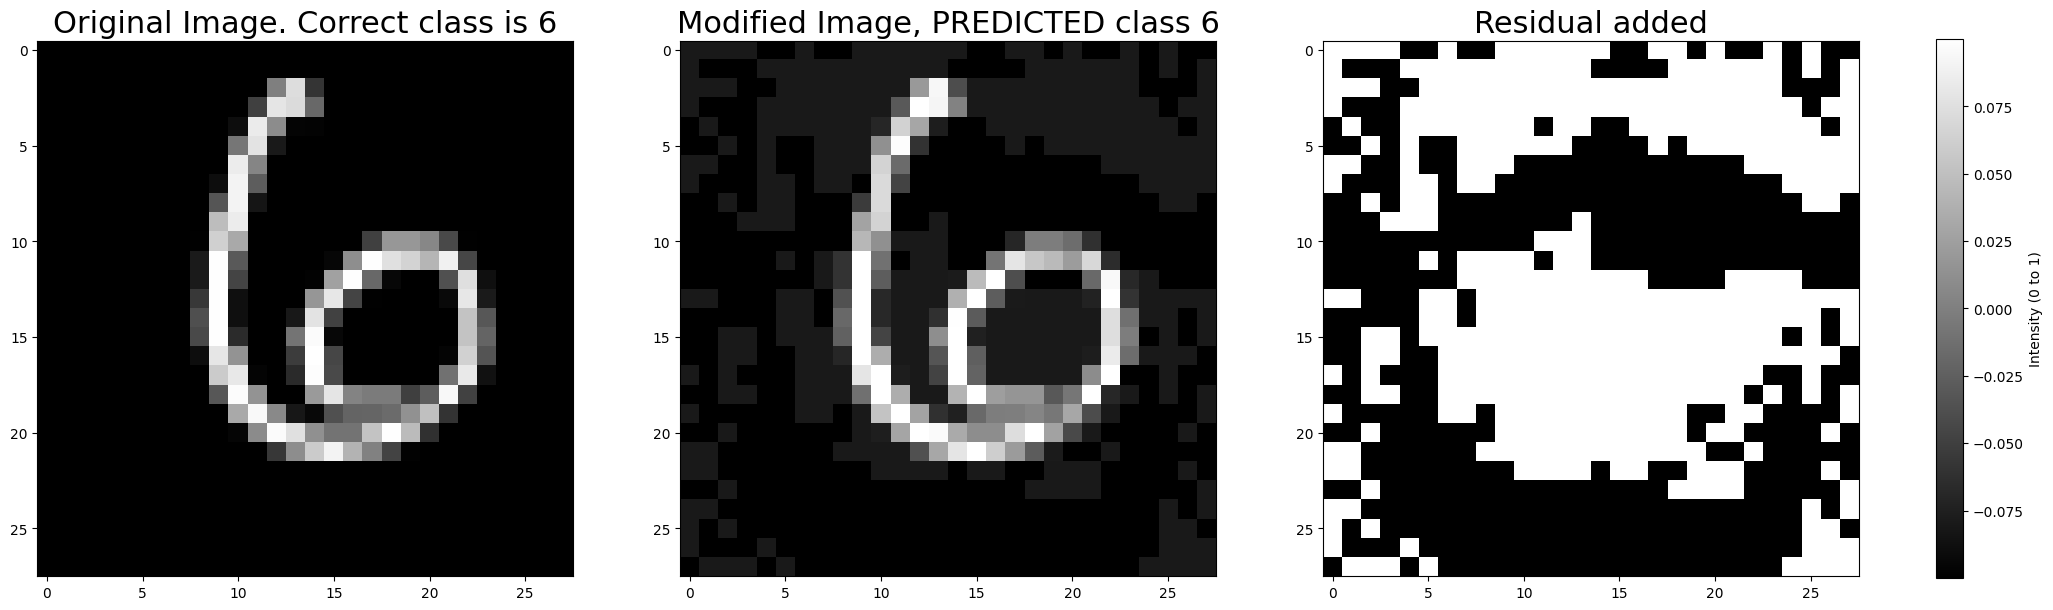

In [74]:
# Initialize parameters
c_raw = torch.tensor([initial_c], requires_grad=True, device=device)  # Learnable raw parameter for c
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r
optimizer = optim.Adam([r, c_raw], lr=lr_adam)  # Adam optimizer for r and c_raw

# Optimization loop
for iter in range(max_iter_adam):
    optimizer.zero_grad()
    c = torch.nn.functional.softplus(c_raw)  # Ensure c > 0
    loss = objective(c, r, testI, l)  # Compute the loss
    loss.backward()  # Backpropagate gradients
    optimizer.step()  # Update r and c_raw

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition is satisfied
    if predicted_label == l:
        print(f"Optimization succeeded at iteration {iter} with c = {c.item():.6f}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=False)
        break
else:
    print("Failed to find adversarial example within the maximum iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)


It does not work properly, since the model still classifies the correct label.

It is recalled that the loss that was used was : 

In [ ]:
loss_f = nn.CrossEntropyLoss()

# Define the loss function : c|r| + \text{loss}_f (x + r, l)
def objective(c, r, x, l):
    x_r = torch.clamp(x + r, 0, 1)  # Ensure valid range for x + r
    pred = model(x_r)  # Get logits from the model
    return c*torch.abs(r).sum() + loss_f(pred, l)

If we try the previous procedure with other losses (such as the $\mathcal{L}^1$-loss or the $\mathcal{L}^2$-loss) let's see at what happens.

In [130]:
class LassoClassificationLoss(nn.Module):
    def __init__(self, lambda_reg=1.0):
        super(LassoClassificationLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.cross_entropy_loss = nn.CrossEntropyLoss()  # Cross Entropy Loss for classification

    def forward(self, predictions, targets, model_params):
        # Compute the CrossEntropy loss
        ce_loss = self.cross_entropy_loss(predictions, targets)

        # Compute the L1 regularization term
        l1_norm = sum(torch.abs(param).sum() for param in model_params)

        # Combine the losses
        loss = ce_loss + self.lambda_reg * l1_norm
        return loss

criterion = LassoClassificationLoss(lambda_reg=0.01)

# Define the loss function : c|r| + \text{loss}_f (x + r, l)
def objective2(c, r, x, l, model, criterion):
    x_r = torch.clamp(x + r, 0, 1)  # Ensure valid range for x + r
    pred = model(x_r)  # Get logits from the model
    params = list(model.parameters())
    return c*torch.abs(r).sum() + criterion(pred, l, params)

Optimization succeeded at iteration 0 with c = 0.693148
Norm Perturbation |r|: 78.2786865234375


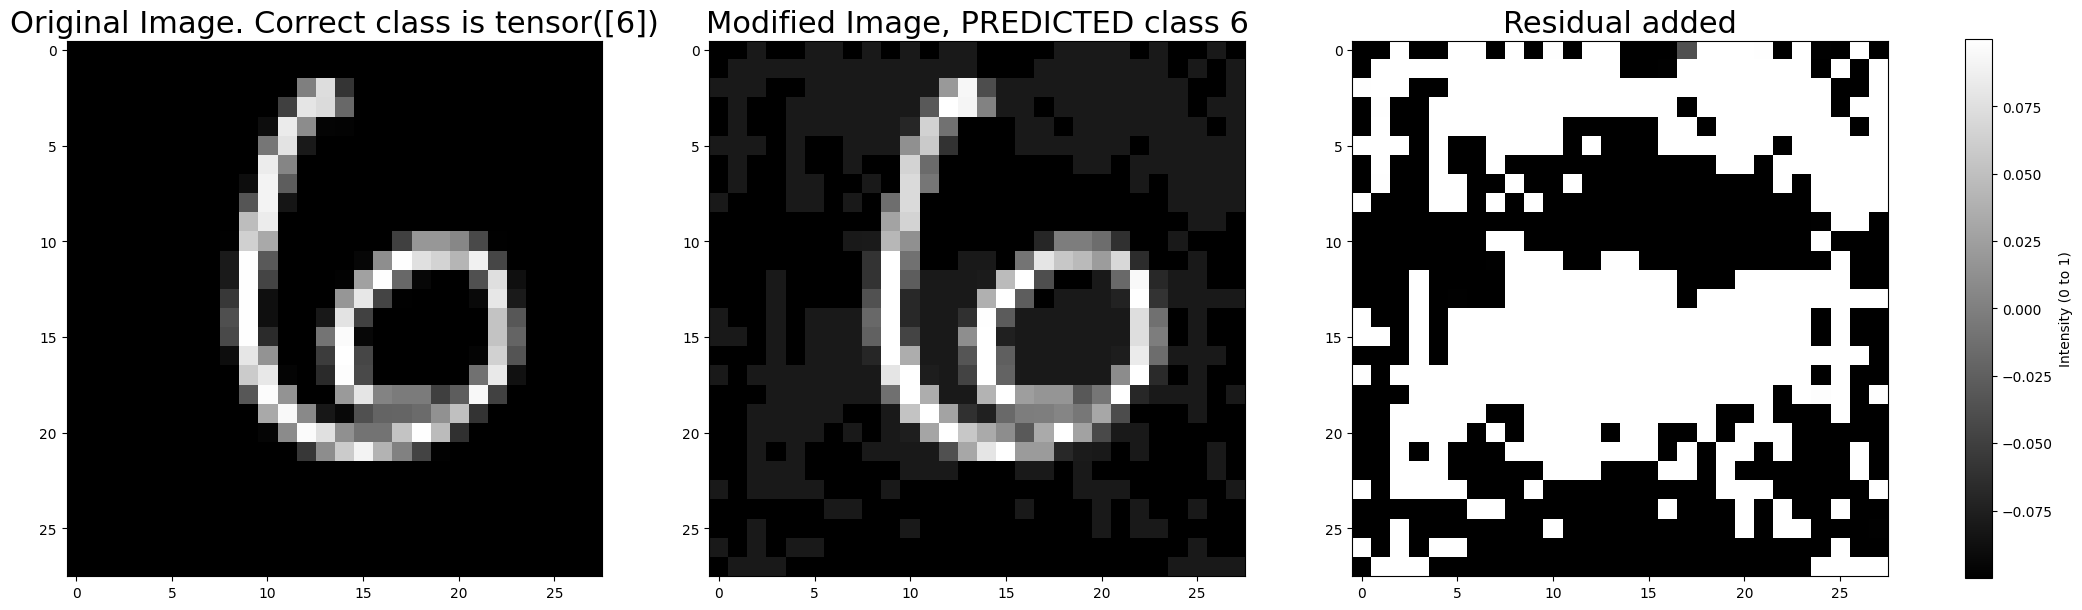

Optimization succeeded at iteration 0 with c = 0.693148
Norm Perturbation |r|: 20.0175838470459


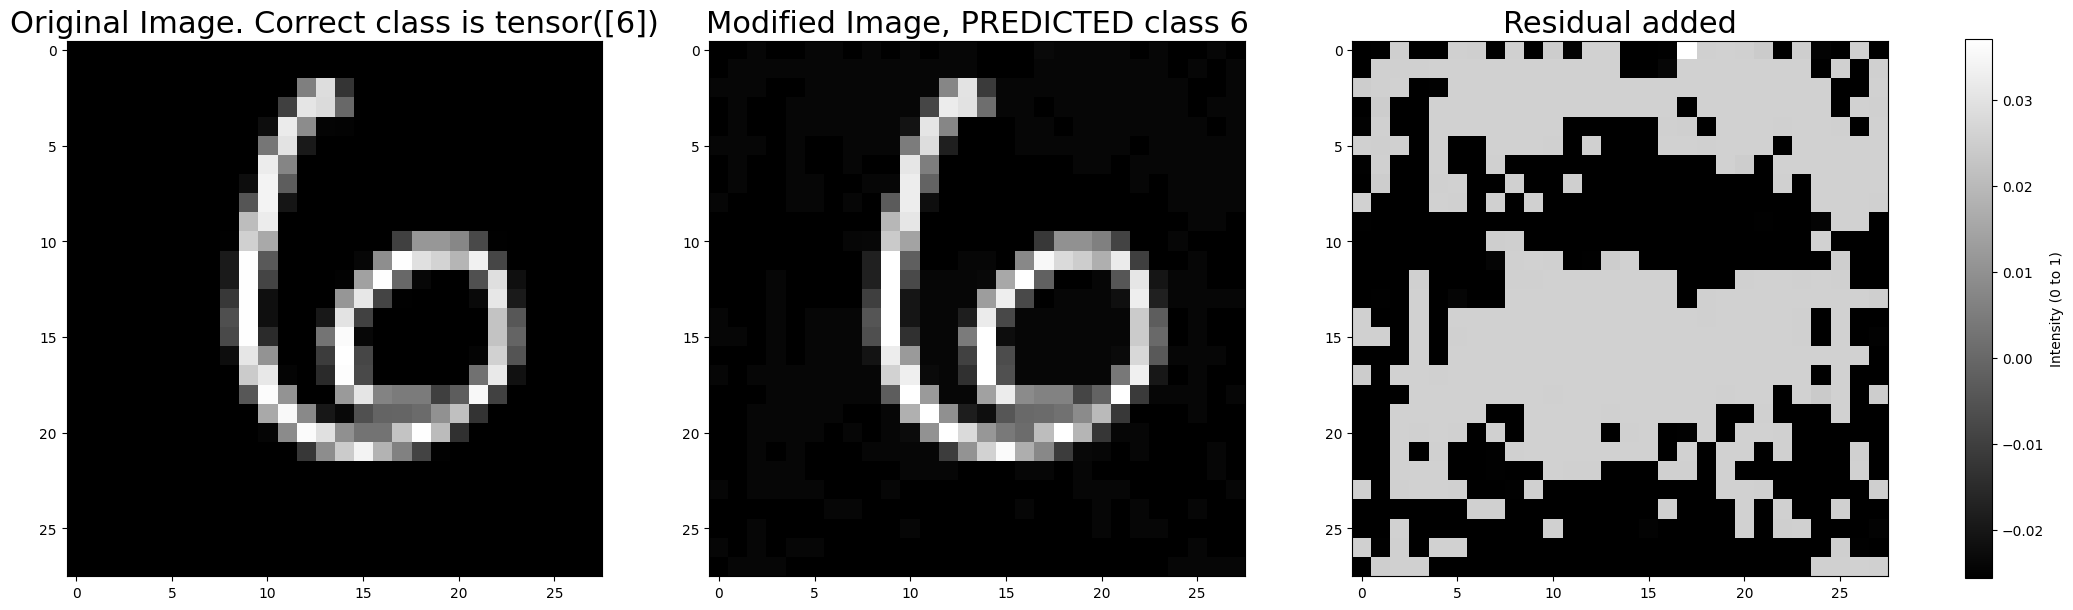

Optimization succeeded at iteration 0 with c = 0.656633
Norm Perturbation |r|: 47.14967346191406


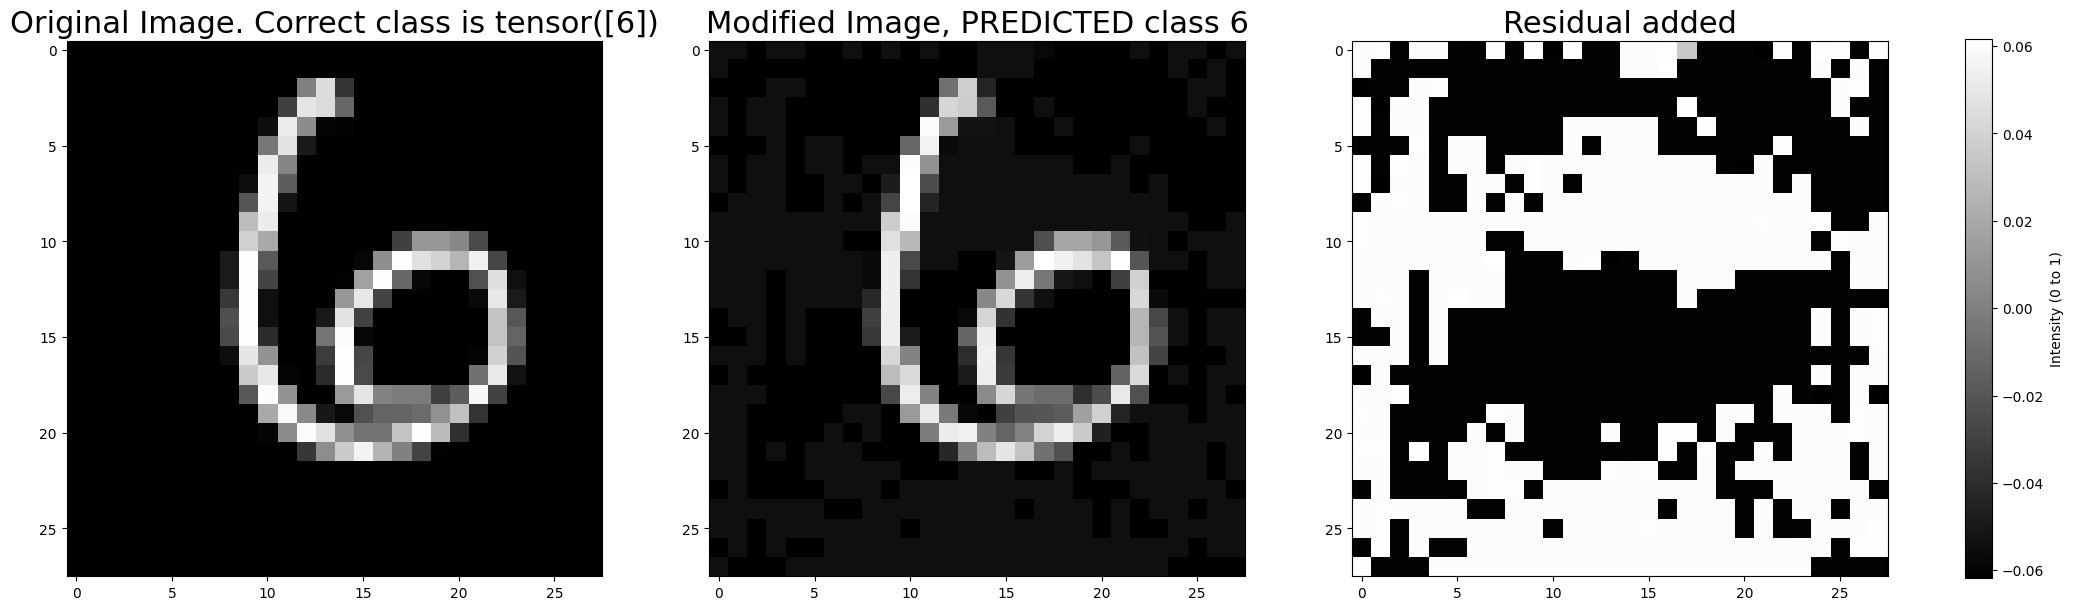

Optimization succeeded at iteration 1 with c = 0.587194
Norm Perturbation |r|: 58.01716613769531


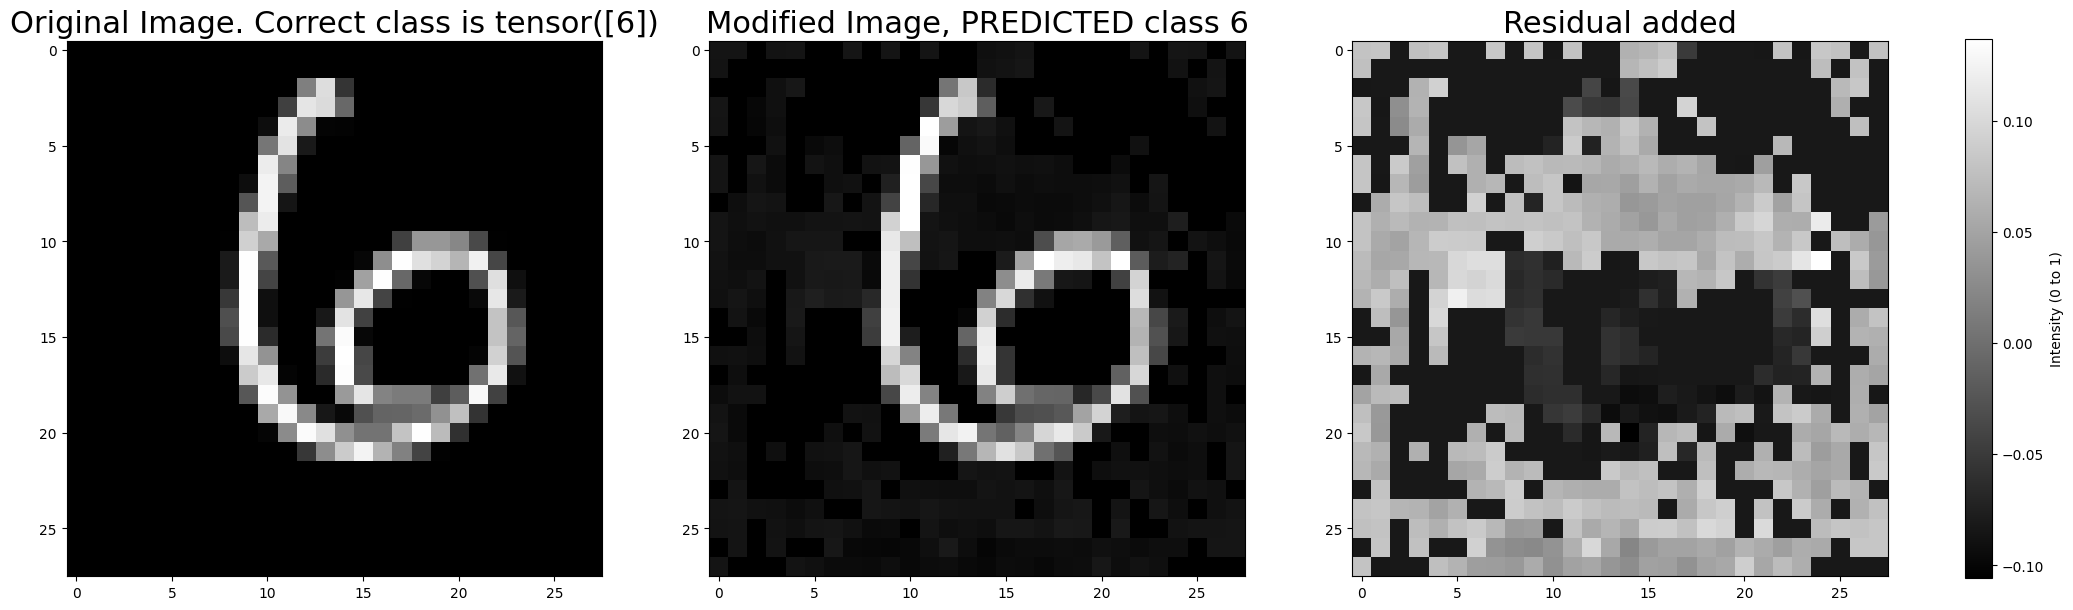

Optimization succeeded at iteration 0 with c = 0.550077
Norm Perturbation |r|: 36.47368240356445


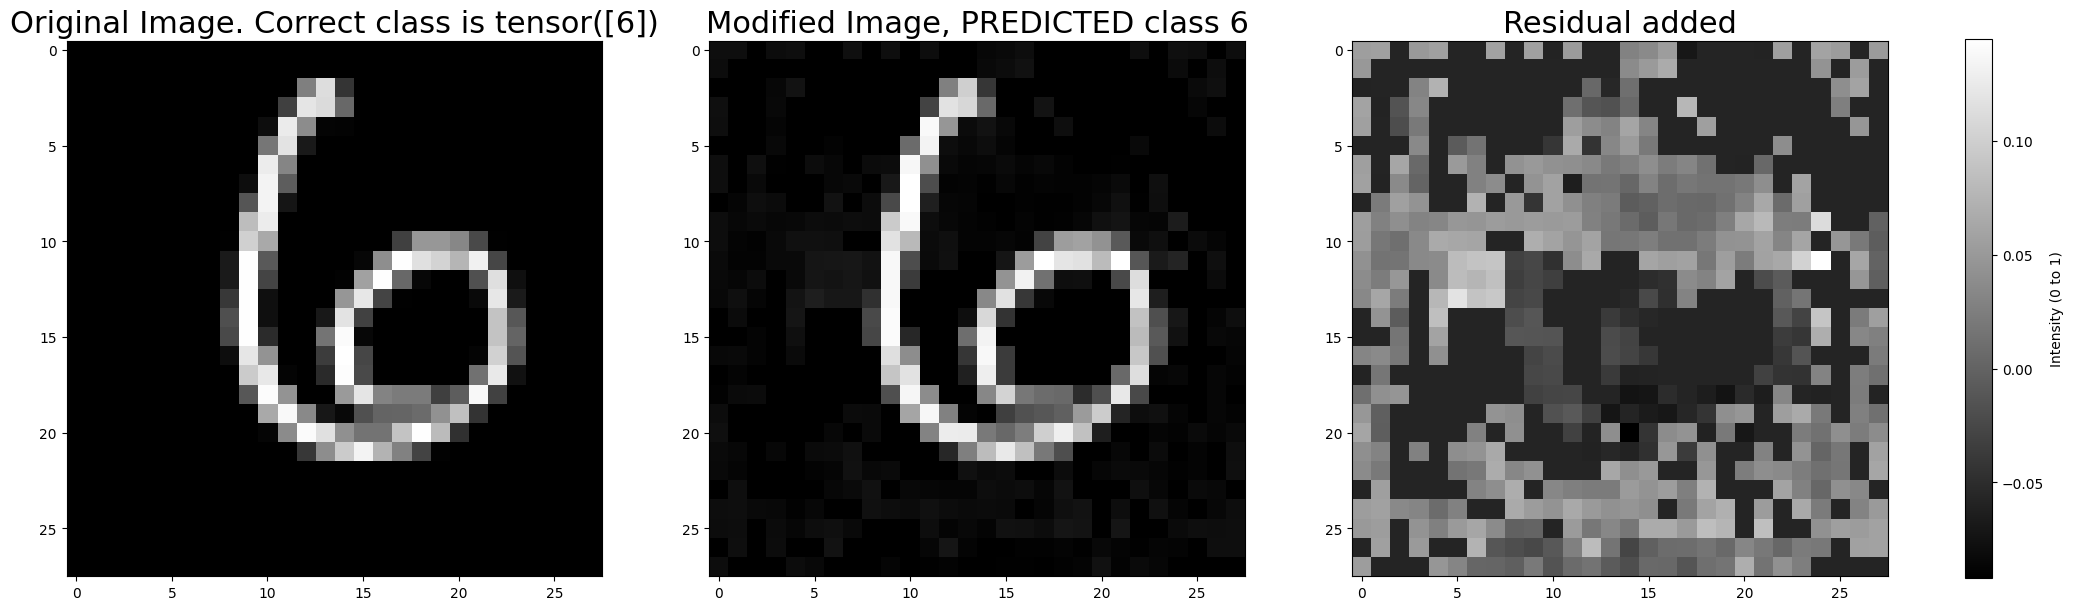

Optimization succeeded at iteration 0 with c = 0.513492
Norm Perturbation |r|: 16.847110748291016


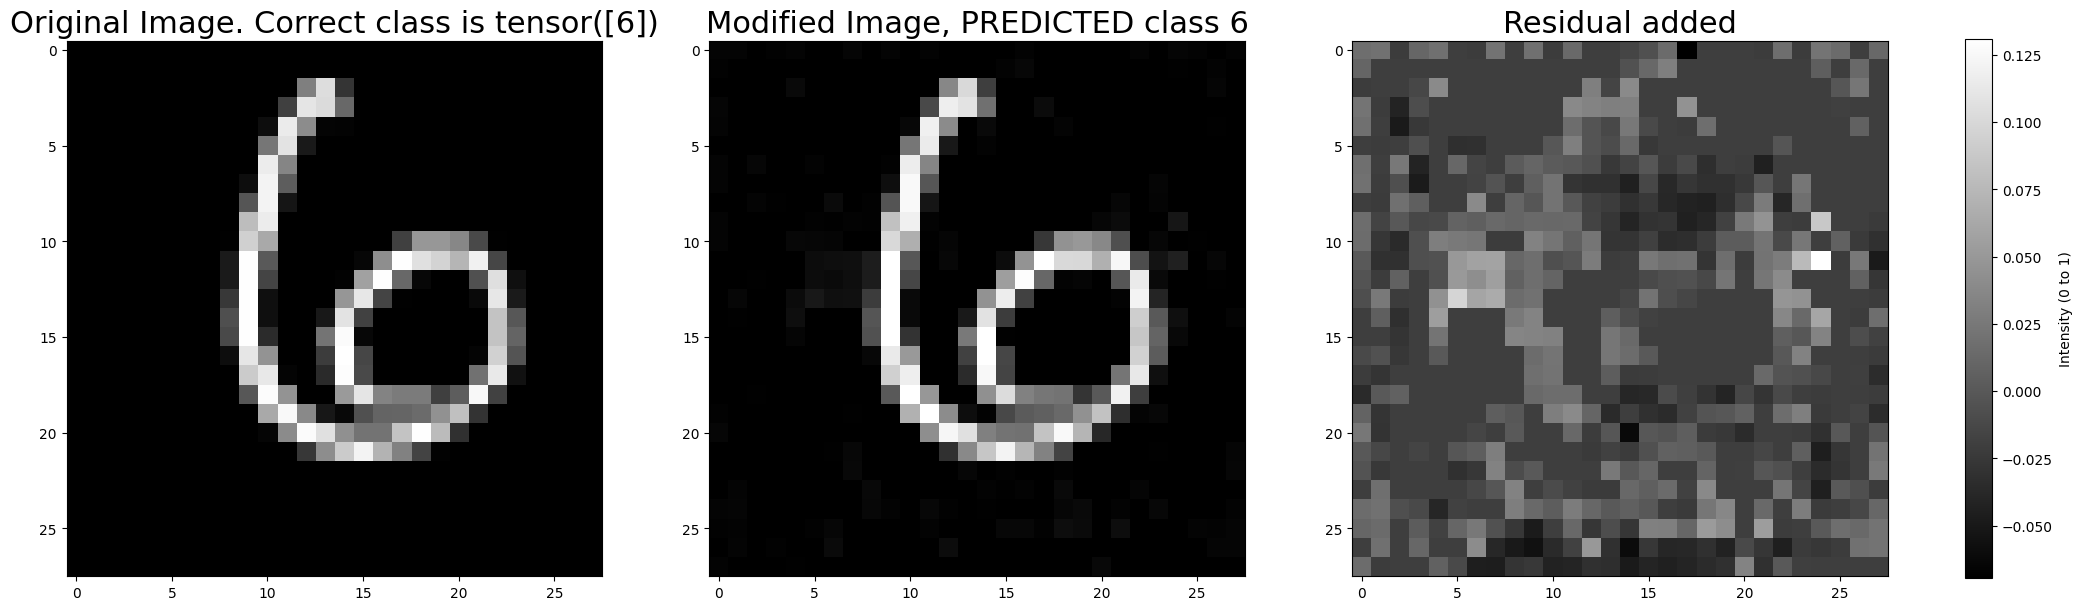

Optimization succeeded at iteration 0 with c = 0.479331
Norm Perturbation |r|: 26.18451690673828


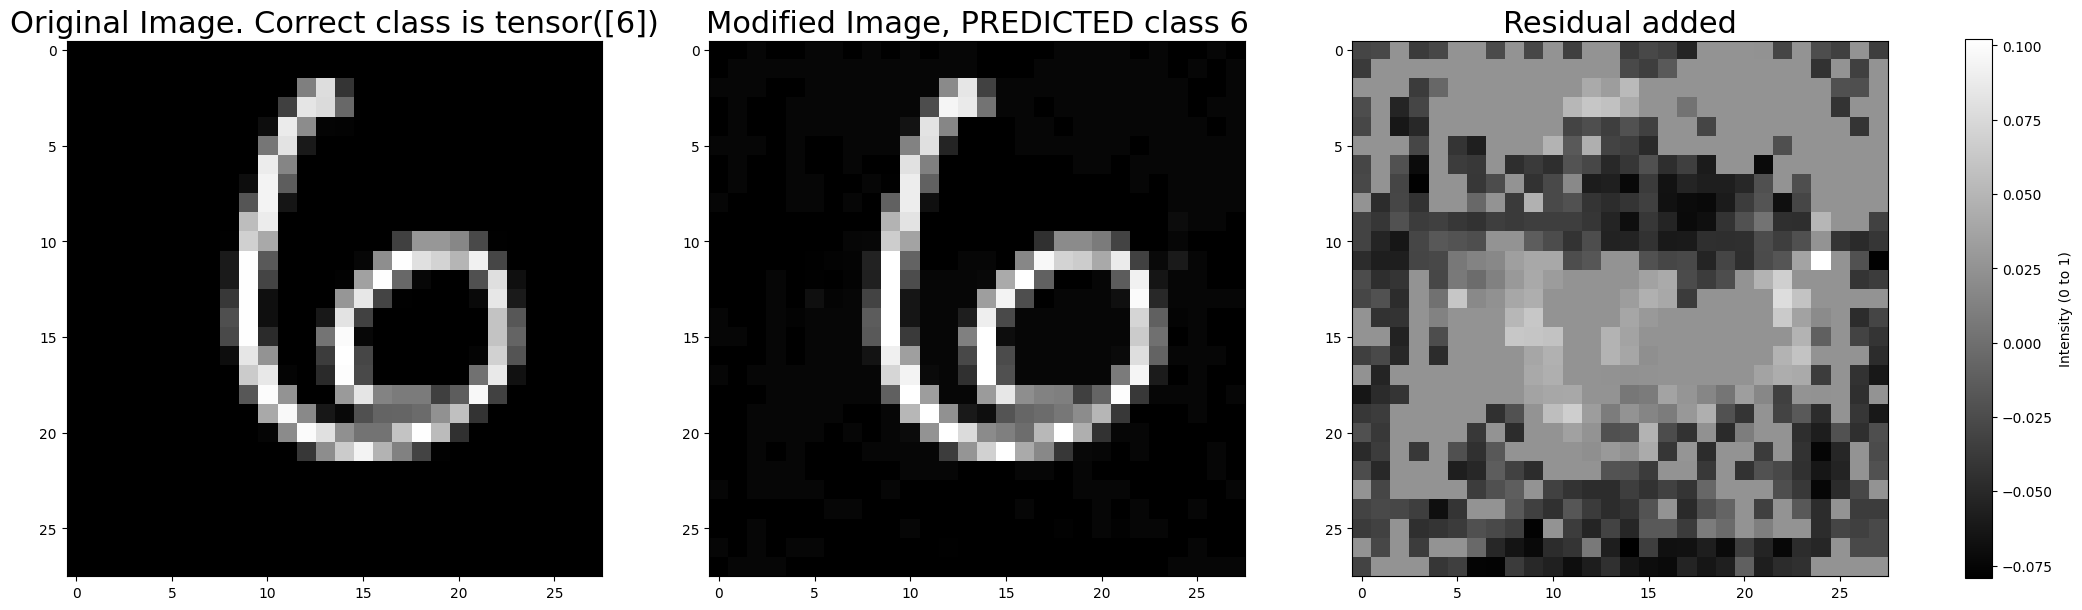

Optimization succeeded at iteration 0 with c = 0.448992
Norm Perturbation |r|: 41.99681091308594


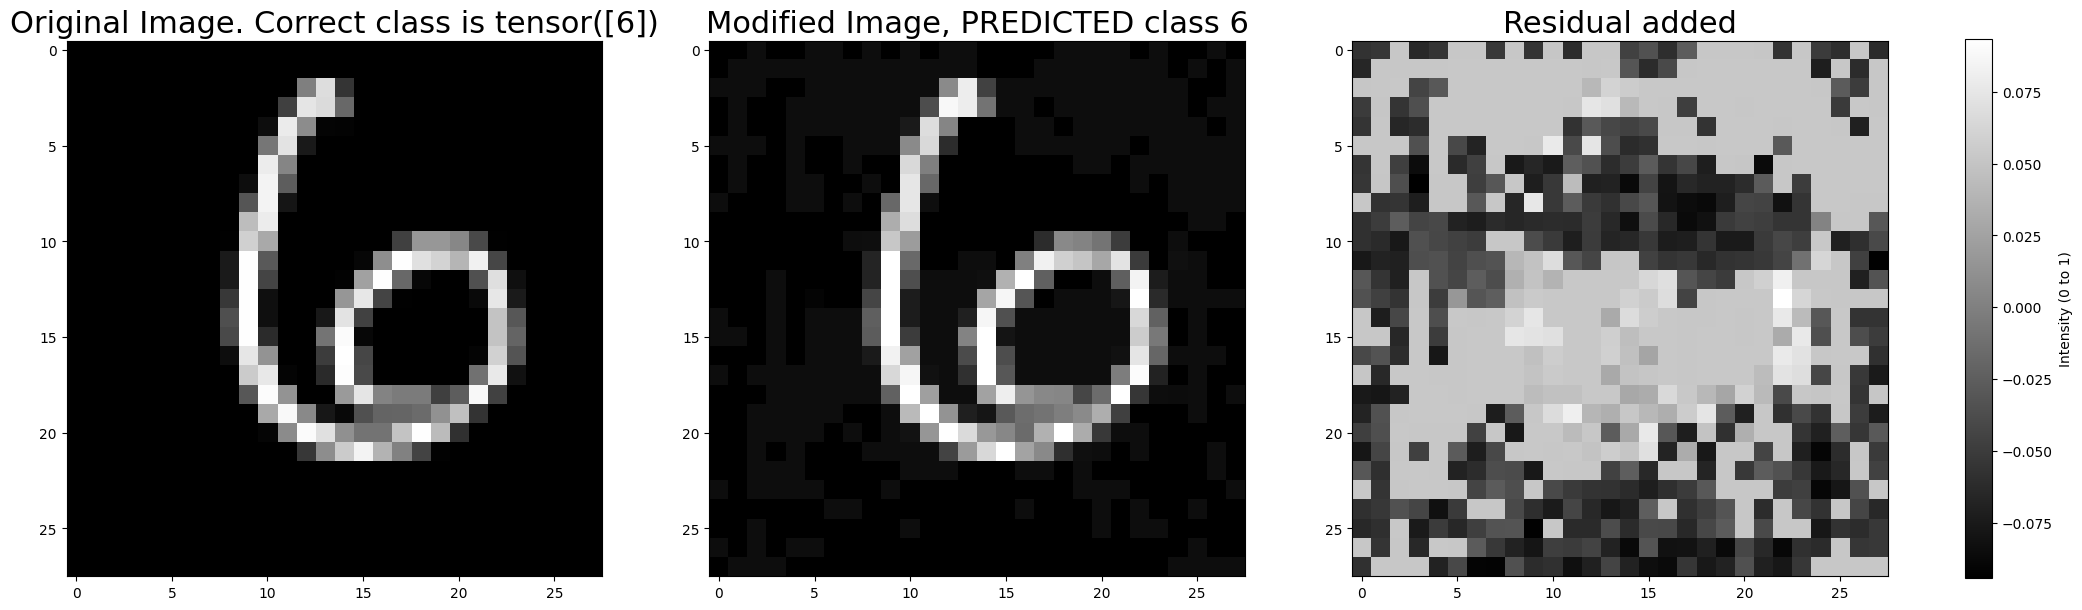

Optimization succeeded at iteration 0 with c = 0.421086
Norm Perturbation |r|: 47.127769470214844


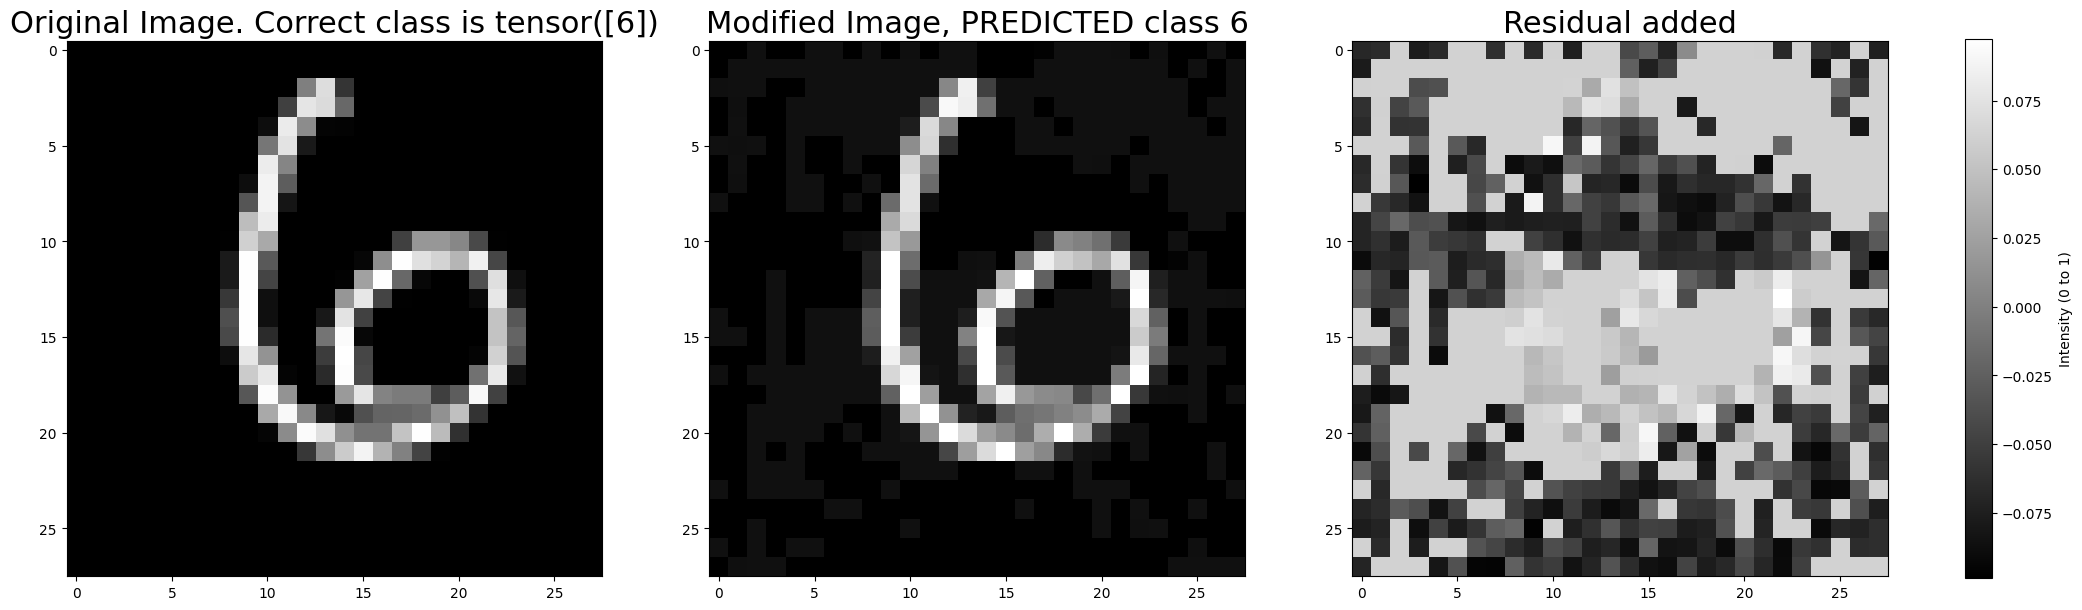

In [132]:
# Initialize parameters
c_raw = torch.tensor([initial_c], requires_grad=True, device=device)  # Learnable raw parameter for c
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r
optimizer = optim.Adam([r, c_raw], lr=lr_adam)  # Adam optimizer for r and c_raw

for lamb in [0.01, 0.1, 0.5, 1, 5, 10, 20, 30, 50]:
    criterion = LassoClassificationLoss(lambda_reg=lamb)
    # Optimization loop
    for iter in range(max_iter_adam):
        optimizer.zero_grad()
        c = torch.nn.functional.softplus(c_raw)  # Ensure c > 0
        loss = objective2(c, r, testI, l, model_10ep, criterion)  # Compute the loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update r and c_raw

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition is satisfied
        if predicted_label == l:
            print(f"Optimization succeeded at iteration {iter} with c = {c.item():.6f}")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
            plot_results(testI, r, x_r, testY, l, fail=False)
            break
    else:
        print("Failed to find adversarial example within the maximum iterations")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=True)


# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and $J(\theta, x, y)$ the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\nabla_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [93]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

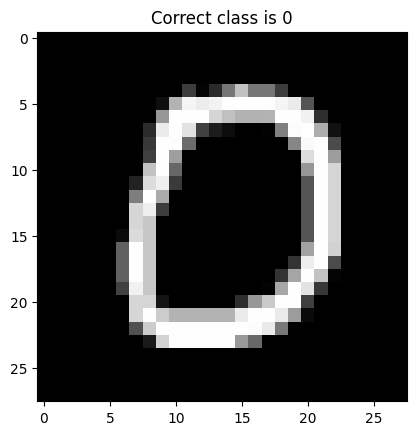

In [94]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 0, Perturbed Class: 5
Optimization successful
Norm Perturbation |r|: 78.39937591552734


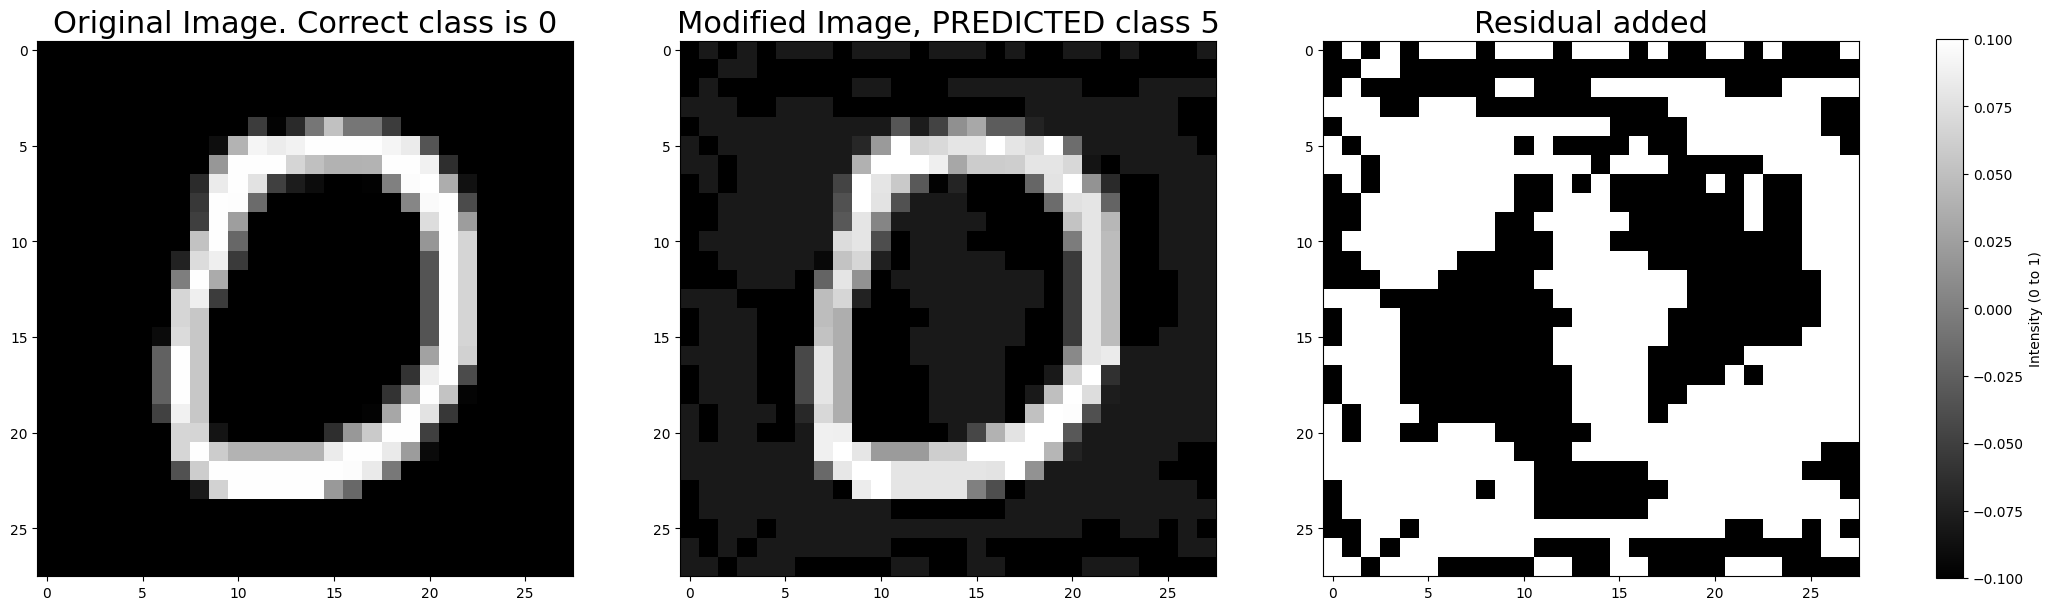

In [99]:
# in the paper, they use eps in {0.007, 0.1, 0.25}, we keep the intermediary 
eps = 0.1  # perturbation size

# Forward pass of X through the model
pred_original = model(X)  
original_class = torch.tensor([0])

# Compute loss
cost = torch.nn.CrossEntropyLoss()(pred_original, original_class)  # Replace XXXXXXXX with CrossEntropyLoss

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
r = eps * X.grad.data.sign()  # Compute the perturbation (gradient sign scaled by epsilon)
Xr = X + r  # Add perturbation to the original image
Xr = torch.clamp(Xr, 0, 1)  # Clamp the perturbed image to ensure valid pixel range [0, 1]

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class = pred_perturbed.argmax(dim=1)  # Get the predicted class for the perturbed input

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

if original_class.item() == perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)
else:
    print(f"Optimization successful")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created). 

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Using epsilon: 0.005 we successfully create 1.10% adversarial examples


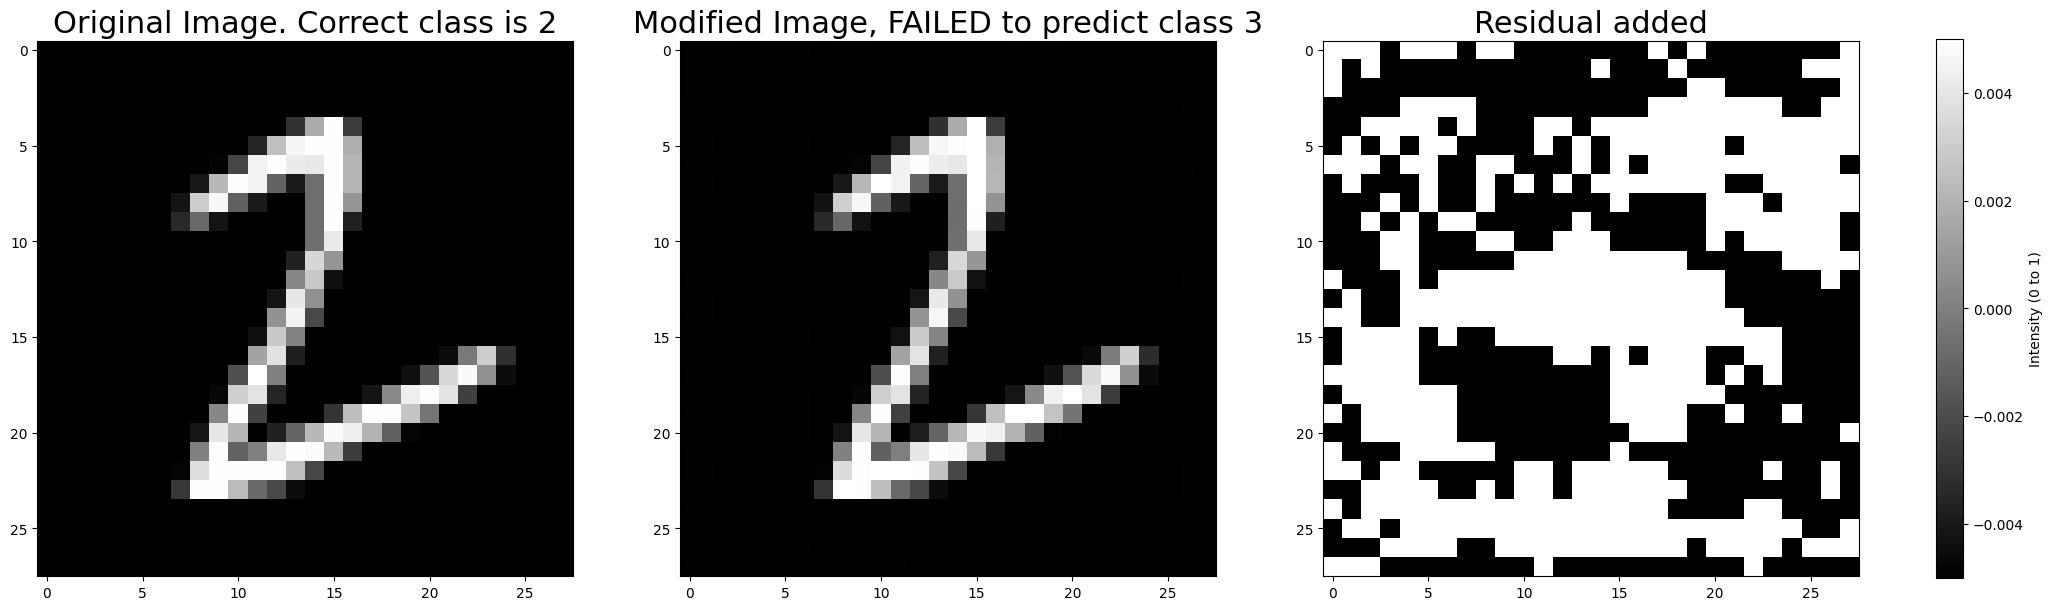

Using epsilon: 0.05 we successfully create 46.36% adversarial examples


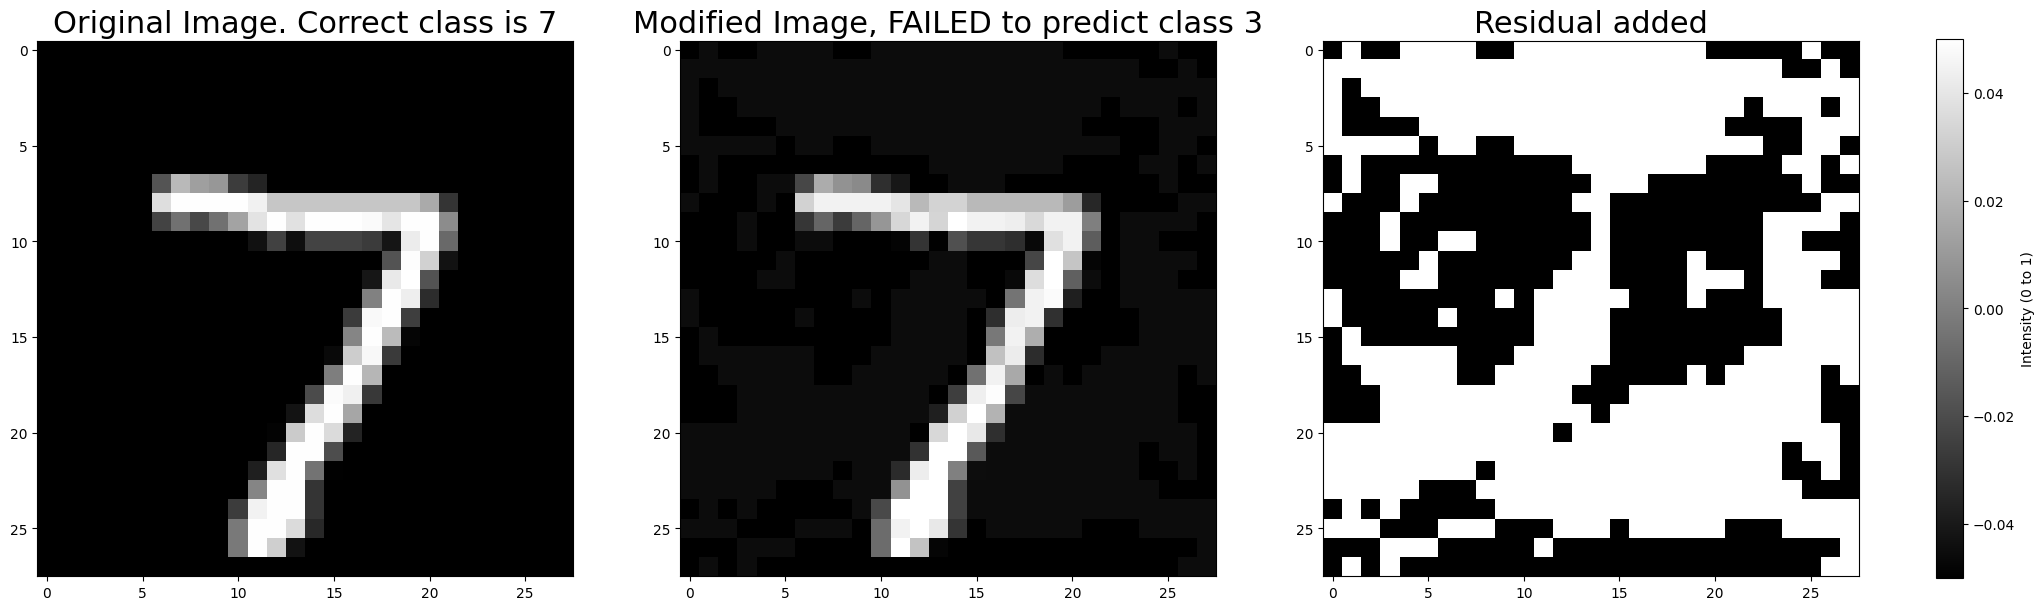

Using epsilon: 0.1 we successfully create 88.34% adversarial examples


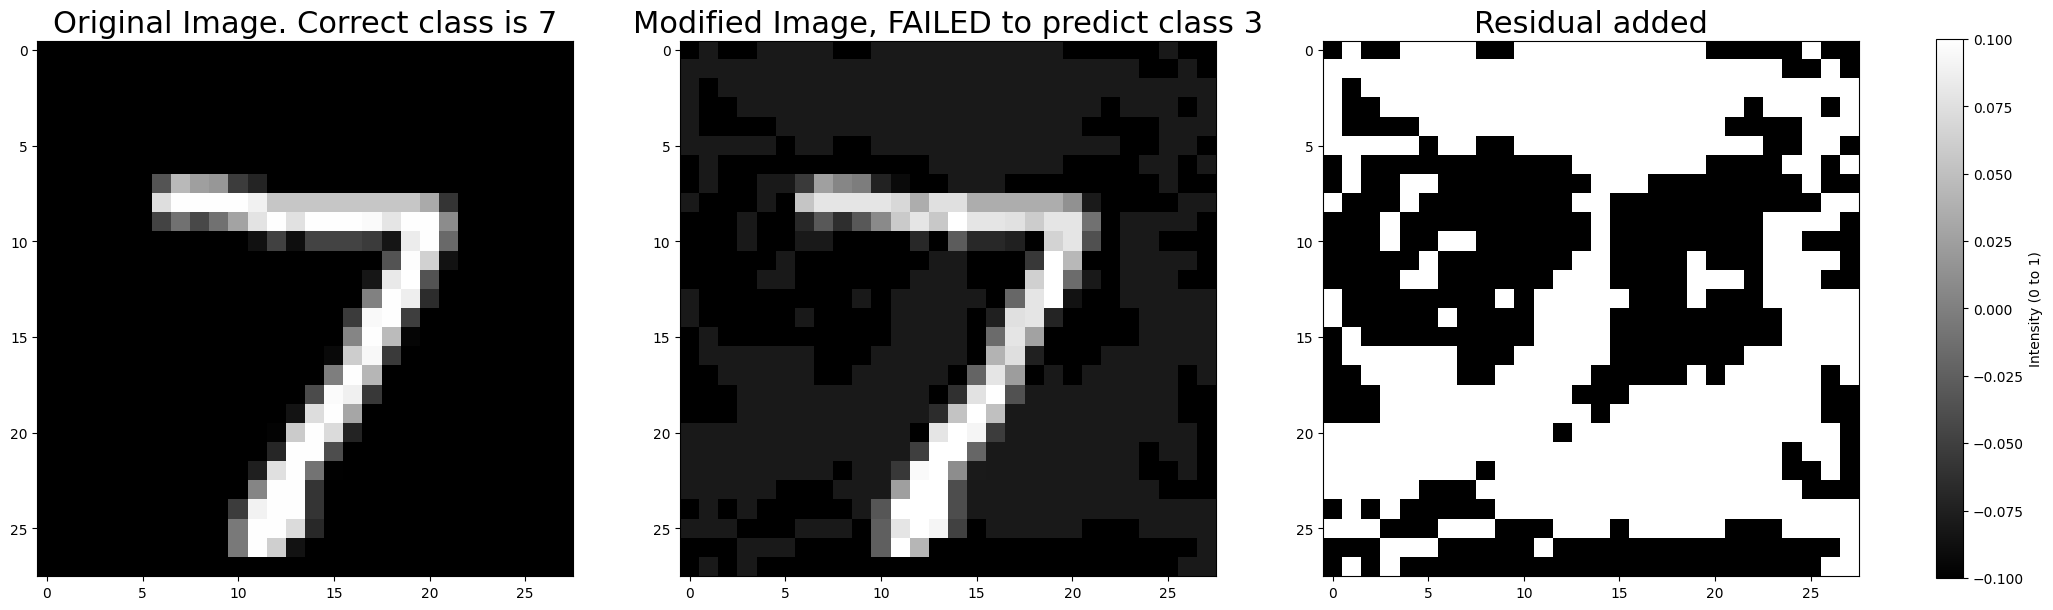

Using epsilon: 0.5 we successfully create 98.19% adversarial examples


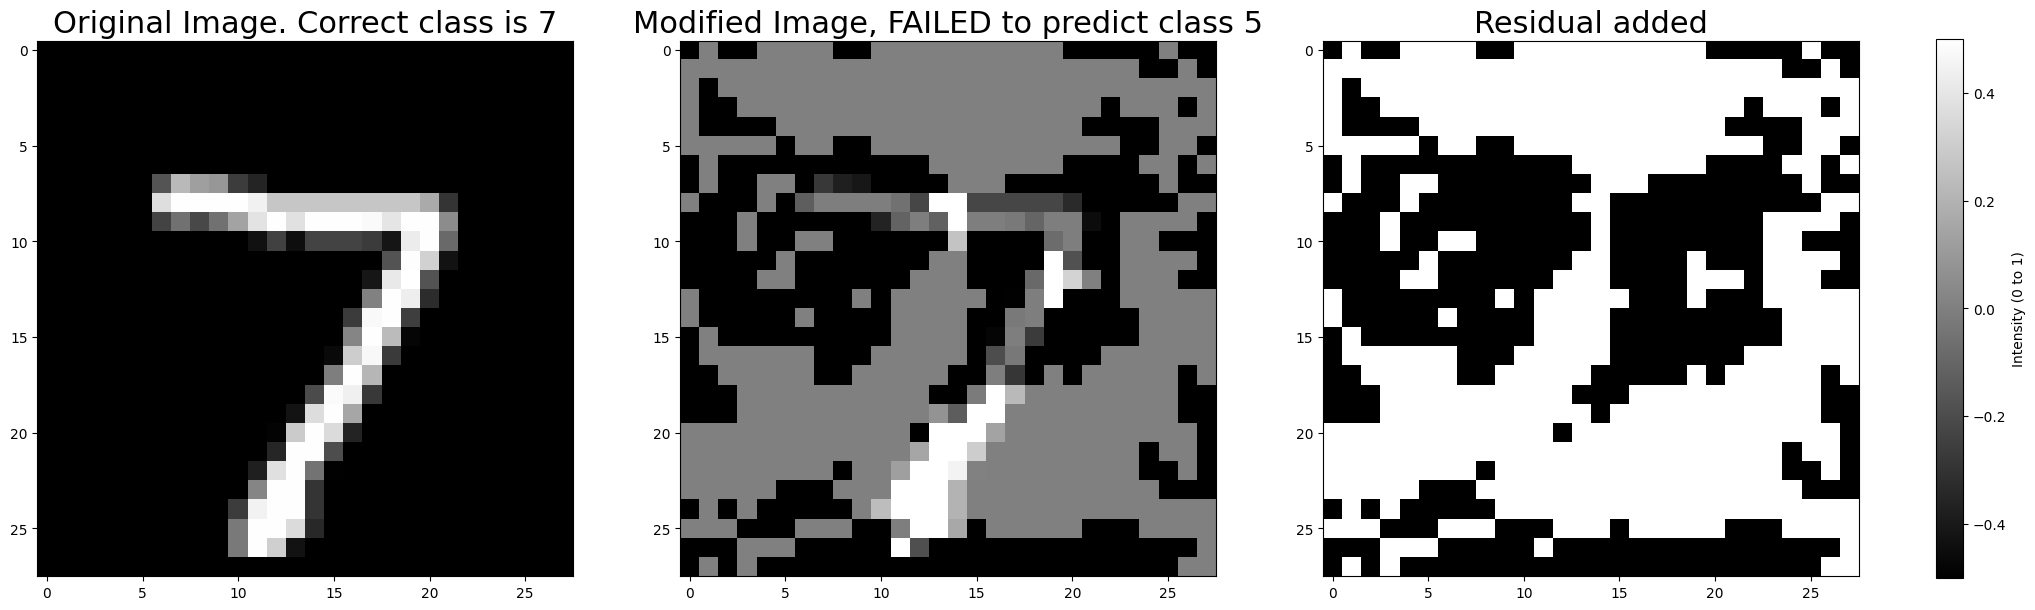

Using epsilon: 0.25 we successfully create 97.68% adversarial examples


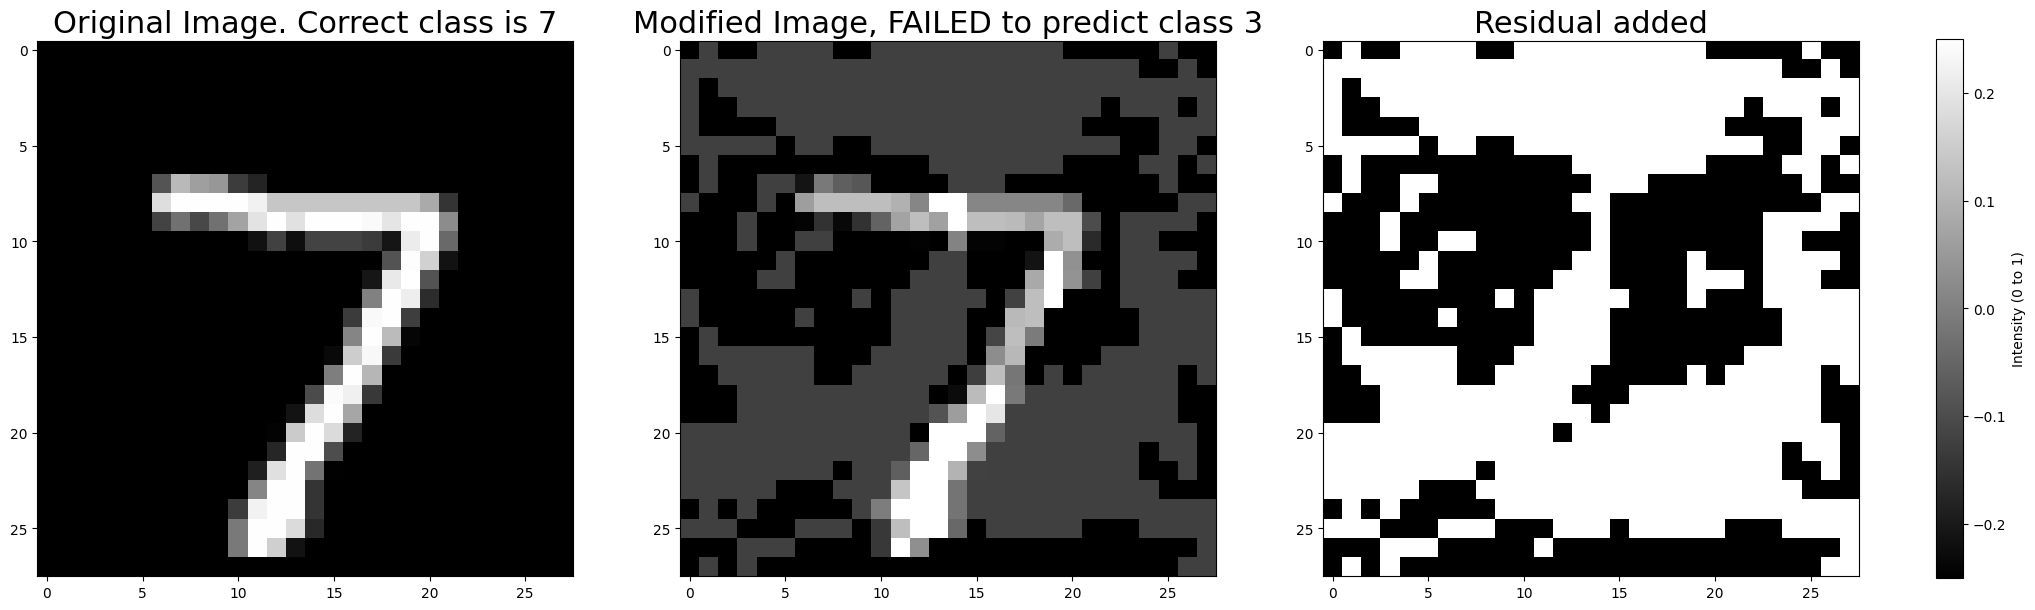

Using epsilon: 0.5 we successfully create 98.19% adversarial examples


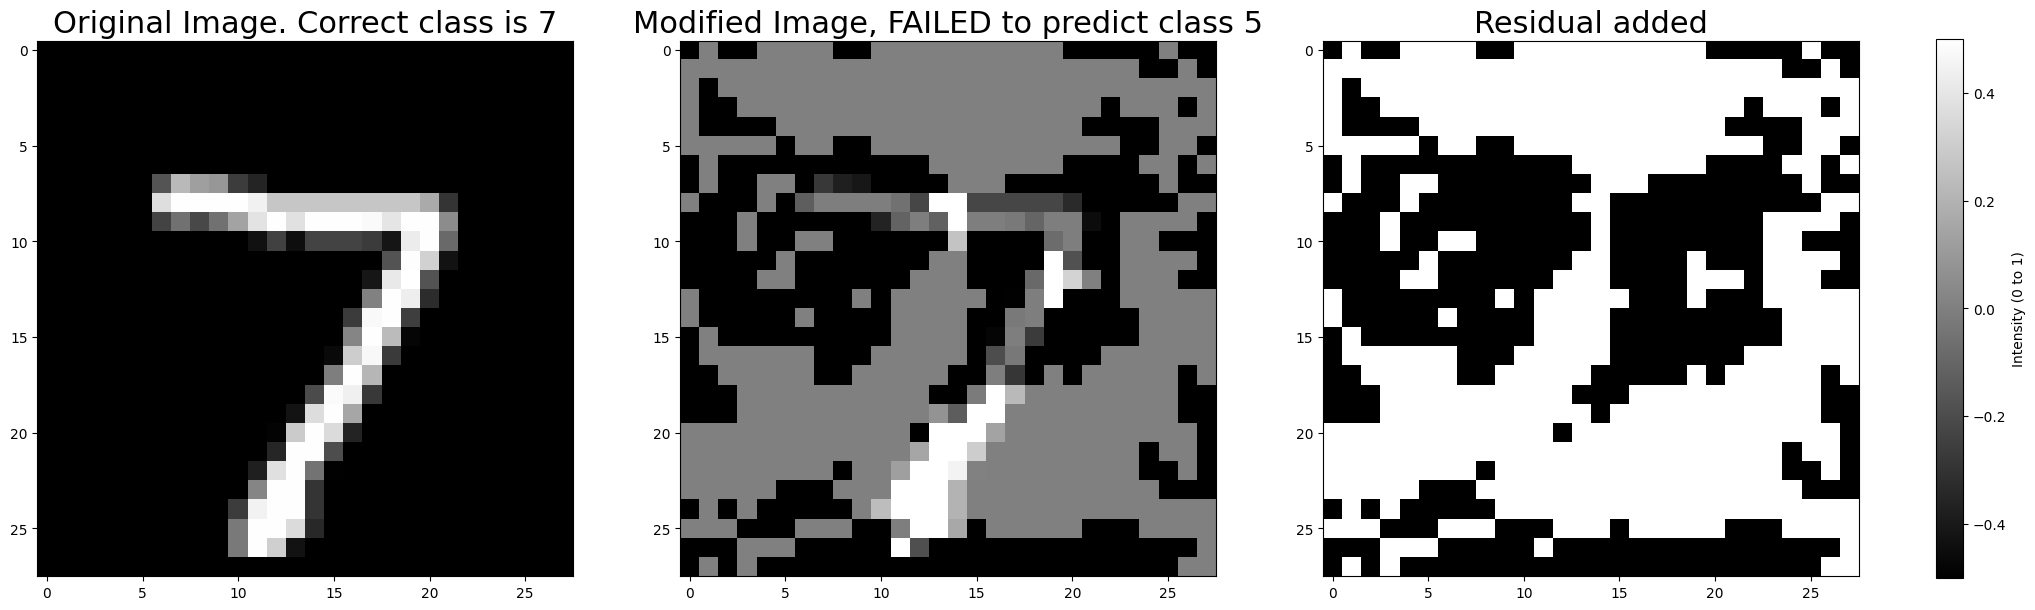

Using epsilon: 0.75 we successfully create 98.50% adversarial examples


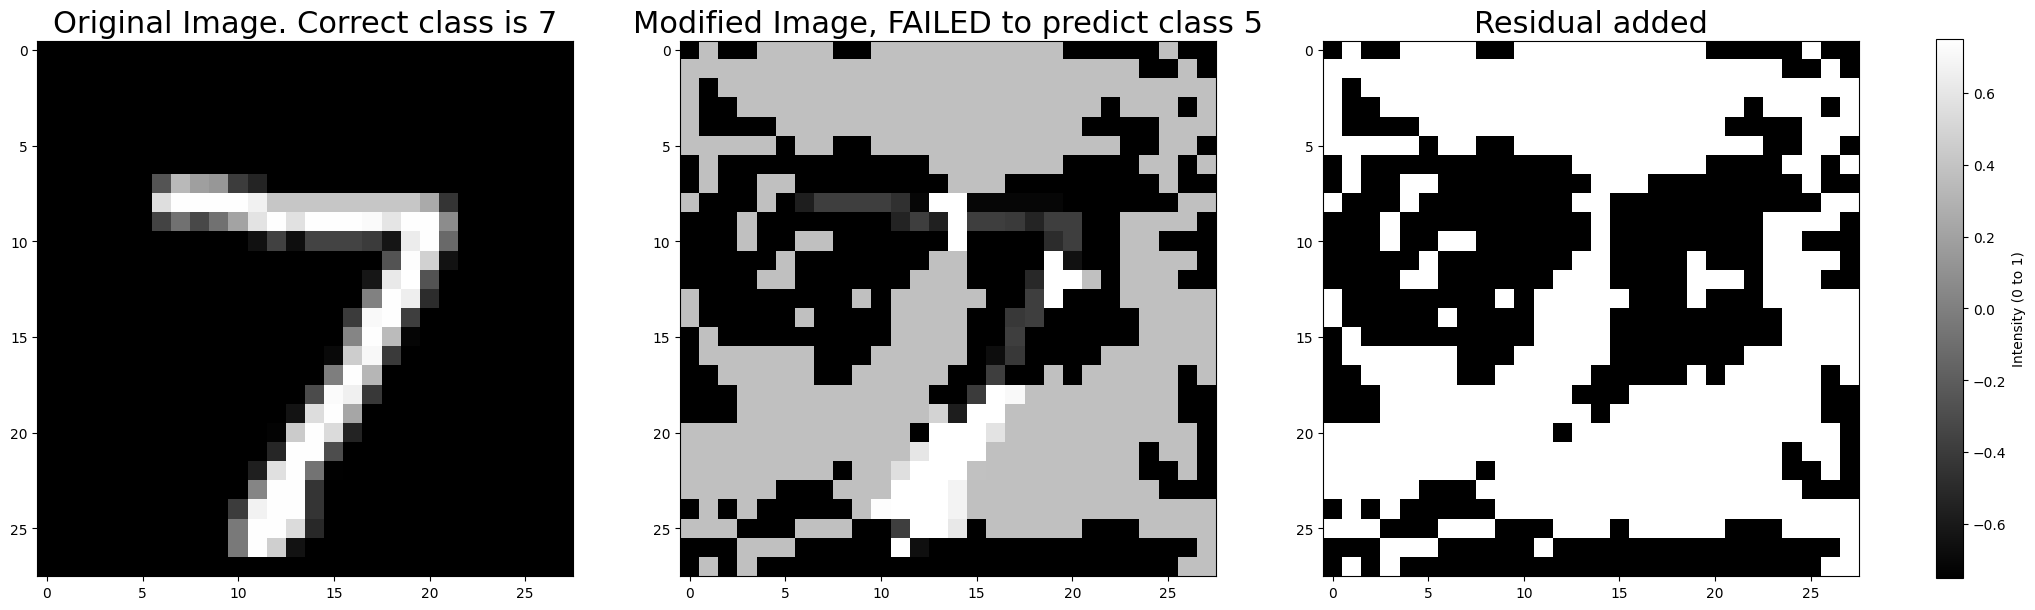

Using epsilon: 0.9 we successfully create 98.60% adversarial examples


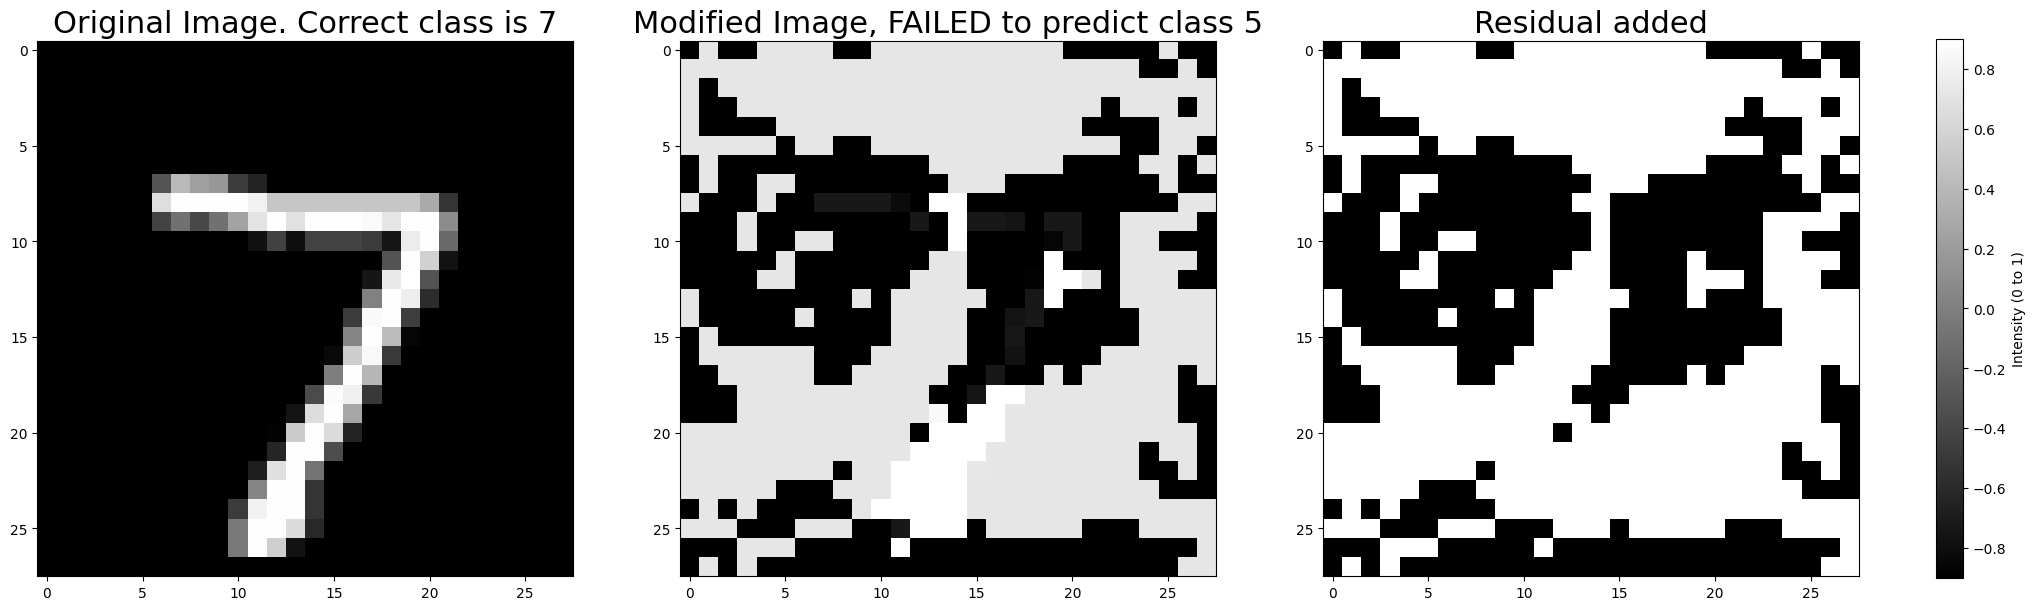

The best epsilon value is 0.9 with a success rate of 98.60%.


In [101]:
def fgsm_attack(X, Y, model, loss_model, eps):
    """
    Performs FGSM attack on a single input image X and label Y.
    Returns the adversarial example (Xr), original class, perturbed class, and perturbation (r).
    """
    X.requires_grad = True  # Enable gradient computation for input
    pred_original = model(X.unsqueeze(0))  # Forward pass, add batch dimension
    original_class = pred_original.argmax(dim=1)

    # Compute loss
    cost = loss_model(pred_original, Y.unsqueeze(0))

    # Zero existing gradients
    model.zero_grad()

    # Backpropagate to compute gradients
    cost.backward()

    # Generate perturbation
    r = eps * X.grad.data.sign()
    Xr = X + r
    Xr = torch.clamp(Xr, 0, 1)  # Clamp to ensure valid pixel values

    # Re-classify the perturbed image
    pred_perturbed = model(Xr.unsqueeze(0))
    perturbed_class = pred_perturbed.argmax(dim=1)

    return Xr, original_class, perturbed_class, r


# Evaluation for multiple epsilon values
eps_values = [0.005, 0.05, 0.1, 0.5, 0.25, 0.5, 0.75, 0.9]
best_eps = None
highest_success_rate = 0

# Loop over each epsilon value
for eps in eps_values:
    adv_examples = []
    success_count = 0
    total_count = 0

    # Loop over all examples in test set
    for X_batch, Y_batch in test_loader:  # Iterate through test batches
        for X, Y in zip(X_batch, Y_batch):
            Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, torch.nn.CrossEntropyLoss(), eps)

            # Check if adversarial example was successful
            if original_class.item() != perturbed_class.item():
                success_count += 1
                adv_examples.append((X, r, Xr, Y, perturbed_class))

            total_count += 1

    # Calculate success rate for this epsilon
    success_rate = (success_count / total_count) * 100
    print(f"Using epsilon: {eps} we successfully create {success_rate:.2f}% adversarial examples")

    # Update best epsilon if this one has the highest success rate
    if success_rate > highest_success_rate:
        highest_success_rate = success_rate
        best_eps = eps

    # Plot one example (optional)
    if len(adv_examples) > 0:
        index = 0
        X, r, Xr, Y, perturbed_class = adv_examples[index]
        plot_results(X, r, Xr, Y, perturbed_class)

# Print best epsilon
print(f"The best epsilon value is {best_eps} with a success rate of {highest_success_rate:.2f}%.")

It looks like the best epsilon value is the greater one ($0.9$). However, for such a value, the modifications made to the original image are clearly visible. However, using $\epsilon = 0.5$ (see above), one successfully creates roughly $50%$ of adversarial examples which modifications are imperceptible to naked eye. 